# Miniproject 1: Image Classification

## Introduction

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://deeplearning.net/tutorial/logreg.html). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that was [recently extended](https://arxiv.org/abs/1702.05373). We break with this tradition (just a little bit) and tackle first the related problem of classifying cropped, downsampled and grayscaled images of house numbers in the [The Street View House Numbers (SVHN) Dataset](http://ufldl.stanford.edu/housenumbers/).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook.

### Your names

Before you start, please enter your full name(s) in the field below; they are used to load the data. The variable student2 may remain empty, if you work alone.

In [1]:
student1 = "Pau Argelaguet Franquelo"
student2 = "Natalie Bolon Brun"

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io

import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from keras.optimizers import SGD, Adam

# you may experiment with different subsets, 
# but make sure in the submission 
# it is generated with the correct random seed for all exercises.
np.random.seed(284216 + 285155)
subset_of_classes = np.random.choice(range(10), 5, replace = False)

Using TensorFlow backend.


### Plotting

In [3]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 16, ydim = 16,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j]+1)%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k]+1)%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig

### Loading and preprocessing the data

The data consists of RGB color images with 32x32 pixels, loaded into an array of dimension 32x32x3x(number of images). We convert them to grayscale (using [this method](https://en.wikipedia.org/wiki/SRGB#The_reverse_transformation)) and we downsample them to images of 16x16 pixels by averaging over patches of 2x2 pixels.

With these preprocessing steps we obviously remove some information that could be helpful in classifying the images. But, since the processed data is much lower dimensional, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), were we want to try many different things without having to wait too long for computations to finish. After having gained some experience, one may want to go back to work on the 32x32 RGB images.


In [4]:
# convert RGB images x to grayscale using the formula for Y_linear in https://en.wikipedia.org/wiki/Grayscale#Colorimetric_(perceptual_luminance-preserving)_conversion_to_grayscale
def grayscale(x):
    x = x.astype('float32')/255
    x = np.piecewise(x, [x <= 0.04045, x > 0.04045], 
                        [lambda x: x/12.92, lambda x: ((x + .055)/1.055)**2.4])
    return .2126 * x[:,:,0,:] + .7152 * x[:,:,1,:]  + .07152 * x[:,:,2,:]

def downsample(x):
    return sum([x[i::2,j::2,:] for i in range(2) for j in range(2)])/4

def preprocess(data):
    gray = grayscale(data['X'])
    downsampled = downsample(gray)
    return (downsampled.reshape(16*16, gray.shape[2]).transpose(),
            data['y'].flatten() - 1)


data_train = scipy.io.loadmat('data/train_32x32.mat')
data_test = scipy.io.loadmat('data/test_32x32.mat')

x_train_all, y_train_all = preprocess(data_train)
x_test_all, y_test_all = preprocess(data_test)

### Selecting a subset of classes

We furter reduce the size of the dataset (and thus reduce computation time) by selecting only the 5 (out of 10 digits) in subset_of_classes.

In [5]:
def extract_classes(x, y, classes):
    indices = []
    labels = []
    count = 0
    for c in classes:
        tmp = np.where(y == c)[0]
        indices.extend(tmp)
        labels.extend(np.ones(len(tmp), dtype='uint8') * count)
        count += 1
    return x[indices], labels

x_train, y_train = extract_classes(x_train_all, y_train_all, subset_of_classes)
x_test, y_test = extract_classes(x_test_all, y_test_all, subset_of_classes)

Let us plot some examples now. The green digit at the bottom left of each image indicates the corresponding label in y_test.
For further usage of the function plot_some_samples, please have a look at its definition in the plotting section.

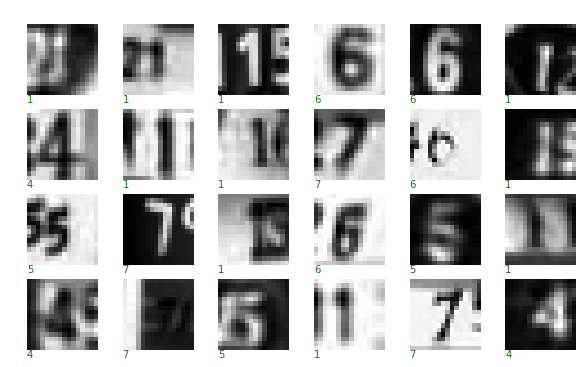

In [6]:
plot_some_samples(x_test, y_test, label_mapping = subset_of_classes);

To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing).

In [7]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

## Exercise 1: No hidden layer

### Description

Define and fit a model without a hidden layer. 

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices, label_mapping = subset_of_classes)`


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution

In [8]:
ex1_model = Sequential([
    Dense(5, input_shape=(256,), activation='softmax'),
])

ex1_model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
ex1_history = ex1_model.fit(x_train, y_train, epochs=300, validation_data=(x_test,y_test), batch_size=128, verbose=1)

Train on 39523 samples, validate on 14002 samples
Epoch 1/300
39523/39523 [==============================] - 1s 14us/step - loss: 1.5786 - acc: 0.3206 - val_loss: 1.5592 - val_acc: 0.3570
Epoch 2/300
39523/39523 [==============================] - 0s 12us/step - loss: 1.5583 - acc: 0.3471 - val_loss: 1.5457 - val_acc: 0.3624
Epoch 3/300
39523/39523 [==============================] - 0s 12us/step - loss: 1.5495 - acc: 0.3492 - val_loss: 1.5388 - val_acc: 0.3642
Epoch 4/300
39523/39523 [==============================] - 0s 12us/step - loss: 1.5437 - acc: 0.3503 - val_loss: 1.5337 - val_acc: 0.3654
Epoch 5/300
39523/39523 [==============================] - 0s 12us/step - loss: 1.5393 - acc: 0.3508 - val_loss: 1.5307 - val_acc: 0.3654
Epoch 6/300
39523/39523 [==============================] - 0s 12us/step - loss: 1.5361 - acc: 0.3520 - val_loss: 1.5277 - val_acc: 0.3669
Epoch 7/300
39523/39523 [==============================] - 0s 12us/step - loss: 1.5336 - acc: 0.3523 - val_loss: 1.5258 - 

39523/39523 [==============================] - 0s 12us/step - loss: 1.4985 - acc: 0.3841 - val_loss: 1.5118 - val_acc: 0.4016
Epoch 60/300
39523/39523 [==============================] - 0s 12us/step - loss: 1.4984 - acc: 0.3842 - val_loss: 1.5118 - val_acc: 0.4019
Epoch 61/300
39523/39523 [==============================] - 0s 12us/step - loss: 1.4981 - acc: 0.3845 - val_loss: 1.5117 - val_acc: 0.4009
Epoch 62/300
39523/39523 [==============================] - 0s 11us/step - loss: 1.4979 - acc: 0.3849 - val_loss: 1.5121 - val_acc: 0.4037
Epoch 63/300
39523/39523 [==============================] - 0s 11us/step - loss: 1.4976 - acc: 0.3848 - val_loss: 1.5121 - val_acc: 0.4071
Epoch 64/300
39523/39523 [==============================] - 0s 11us/step - loss: 1.4973 - acc: 0.3850 - val_loss: 1.5132 - val_acc: 0.4109
Epoch 65/300
39523/39523 [==============================] - 0s 11us/step - loss: 1.4971 - acc: 0.3855 - val_loss: 1.5146 - val_acc: 0.4137
Epoch 66/300
39523/39523 [==============

Epoch 118/300
39523/39523 [==============================] - 0s 12us/step - loss: 1.4891 - acc: 0.3950 - val_loss: 1.5155 - val_acc: 0.4170
Epoch 119/300
39523/39523 [==============================] - 0s 12us/step - loss: 1.4890 - acc: 0.3950 - val_loss: 1.5154 - val_acc: 0.4138
Epoch 120/300
39523/39523 [==============================] - 0s 11us/step - loss: 1.4888 - acc: 0.3961 - val_loss: 1.5154 - val_acc: 0.4147
Epoch 121/300
39523/39523 [==============================] - 0s 11us/step - loss: 1.4888 - acc: 0.3953 - val_loss: 1.5152 - val_acc: 0.4124
Epoch 122/300
39523/39523 [==============================] - 1s 24us/step - loss: 1.4886 - acc: 0.3961 - val_loss: 1.5159 - val_acc: 0.4112
Epoch 123/300
39523/39523 [==============================] - 0s 11us/step - loss: 1.4886 - acc: 0.3961 - val_loss: 1.5153 - val_acc: 0.4133
Epoch 124/300
39523/39523 [==============================] - 0s 11us/step - loss: 1.4884 - acc: 0.3965 - val_loss: 1.5151 - val_acc: 0.4106
Epoch 125/300
39523/

39523/39523 [==============================] - 0s 11us/step - loss: 1.4845 - acc: 0.4001 - val_loss: 1.5179 - val_acc: 0.4159
Epoch 177/300
39523/39523 [==============================] - 0s 12us/step - loss: 1.4844 - acc: 0.4007 - val_loss: 1.5196 - val_acc: 0.4202
Epoch 178/300
39523/39523 [==============================] - 0s 11us/step - loss: 1.4844 - acc: 0.4020 - val_loss: 1.5174 - val_acc: 0.4132
Epoch 179/300
39523/39523 [==============================] - 0s 11us/step - loss: 1.4843 - acc: 0.4012 - val_loss: 1.5177 - val_acc: 0.4165
Epoch 180/300
39523/39523 [==============================] - 0s 11us/step - loss: 1.4842 - acc: 0.4009 - val_loss: 1.5182 - val_acc: 0.4184
Epoch 181/300
39523/39523 [==============================] - 1s 33us/step - loss: 1.4842 - acc: 0.4014 - val_loss: 1.5189 - val_acc: 0.4182
Epoch 182/300
39523/39523 [==============================] - 0s 11us/step - loss: 1.4840 - acc: 0.4014 - val_loss: 1.5187 - val_acc: 0.4150
Epoch 183/300
39523/39523 [=======

39523/39523 [==============================] - 0s 11us/step - loss: 1.4815 - acc: 0.4045 - val_loss: 1.5198 - val_acc: 0.4169
Epoch 235/300
39523/39523 [==============================] - 0s 11us/step - loss: 1.4815 - acc: 0.4049 - val_loss: 1.5194 - val_acc: 0.4149
Epoch 236/300
39523/39523 [==============================] - 0s 11us/step - loss: 1.4815 - acc: 0.4045 - val_loss: 1.5192 - val_acc: 0.4140
Epoch 237/300
39523/39523 [==============================] - 0s 11us/step - loss: 1.4815 - acc: 0.4042 - val_loss: 1.5195 - val_acc: 0.4171
Epoch 238/300
39523/39523 [==============================] - 0s 11us/step - loss: 1.4815 - acc: 0.4046 - val_loss: 1.5201 - val_acc: 0.4175
Epoch 239/300
39523/39523 [==============================] - 0s 11us/step - loss: 1.4814 - acc: 0.4049 - val_loss: 1.5197 - val_acc: 0.4171
Epoch 240/300
39523/39523 [==============================] - 0s 12us/step - loss: 1.4813 - acc: 0.4051 - val_loss: 1.5199 - val_acc: 0.4171
Epoch 241/300
39523/39523 [=======

39523/39523 [==============================] - 0s 11us/step - loss: 1.4795 - acc: 0.4067 - val_loss: 1.5207 - val_acc: 0.4167
Epoch 293/300
39523/39523 [==============================] - 0s 12us/step - loss: 1.4795 - acc: 0.4072 - val_loss: 1.5210 - val_acc: 0.4175
Epoch 294/300
39523/39523 [==============================] - 0s 11us/step - loss: 1.4794 - acc: 0.4065 - val_loss: 1.5236 - val_acc: 0.4215
Epoch 295/300
39523/39523 [==============================] - 0s 11us/step - loss: 1.4794 - acc: 0.4076 - val_loss: 1.5217 - val_acc: 0.4179
Epoch 296/300
39523/39523 [==============================] - 0s 12us/step - loss: 1.4794 - acc: 0.4074 - val_loss: 1.5214 - val_acc: 0.4145
Epoch 297/300
39523/39523 [==============================] - 0s 12us/step - loss: 1.4794 - acc: 0.4068 - val_loss: 1.5217 - val_acc: 0.4183
Epoch 298/300
39523/39523 [==============================] - 0s 11us/step - loss: 1.4793 - acc: 0.4070 - val_loss: 1.5208 - val_acc: 0.4157
Epoch 299/300
39523/39523 [=======

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 5)                 1285      
Total params: 1,285
Trainable params: 1,285
Non-trainable params: 0
_________________________________________________________________


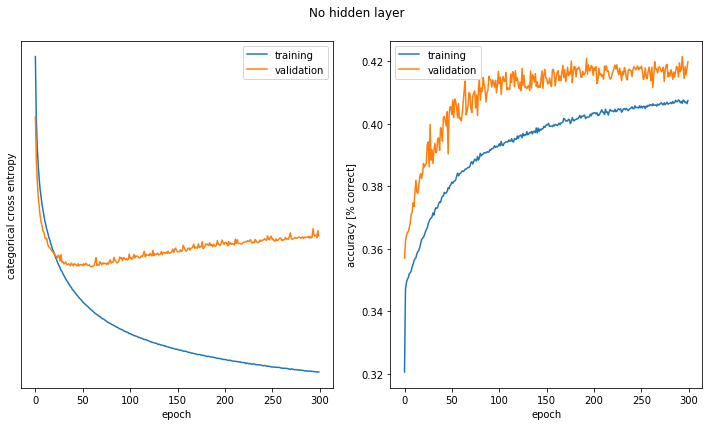

In [9]:
ex1_model.summary()
plot_history(ex1_history, "No hidden layer")
plt.show()

In [10]:
score = ex1_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.52143010942
Test accuracy: 0.419868590202


In [11]:
yhat_test = ex1_model.predict_on_batch(x_test)
error = np.linalg.norm(((yhat_test.round()) - y_test),axis=1)
error_indices = np.nonzero(error)[0]

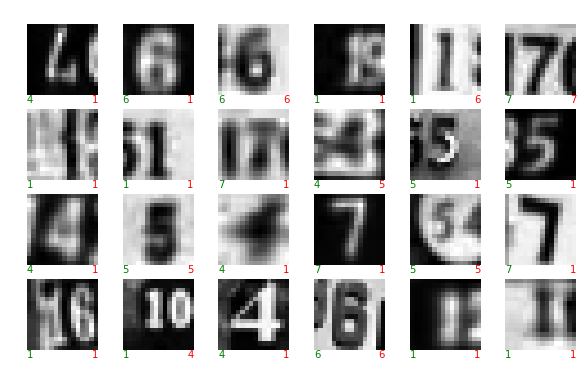

In [12]:
plot_some_samples(x_test, y_test, yhat_test, error_indices, label_mapping = subset_of_classes)
plt.show()

## Exercise 2: One hidden layer, different optizimizers
### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 64 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to inspect your model.
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent and answer the question below.
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam).
4. Plot the learning curves of SGD with a reasonable learning rate together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot.

### Solution

In [13]:
ex2_model_sgd = Sequential([
    Dense(64, input_shape=(256,), activation='relu'),
    Dense(5, activation='softmax'),
])

ex2_model_sgd.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________


In [14]:
lrates = [0.01, 0.05, 0.1, 0.5, 1, 2]
histories = []
for lrate in lrates:
    ex2_model_sgd.compile(optimizer=SGD(lr=lrate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    histories.append(
        ex2_model_sgd.fit(x_train, y_train, epochs=50, validation_data=(x_test,y_test), batch_size=128, verbose=1))

Train on 39523 samples, validate on 14002 samples
Epoch 1/50
39523/39523 [==============================] - 1s 19us/step - loss: 1.5535 - acc: 0.3412 - val_loss: 1.5291 - val_acc: 0.3642
Epoch 2/50
39523/39523 [==============================] - 1s 24us/step - loss: 1.5304 - acc: 0.3513 - val_loss: 1.5126 - val_acc: 0.3663
Epoch 3/50
39523/39523 [==============================] - 1s 31us/step - loss: 1.5167 - acc: 0.3518 - val_loss: 1.4979 - val_acc: 0.3722
Epoch 4/50
39523/39523 [==============================] - 1s 18us/step - loss: 1.5040 - acc: 0.3543 - val_loss: 1.4819 - val_acc: 0.3741
Epoch 5/50
39523/39523 [==============================] - 1s 18us/step - loss: 1.4912 - acc: 0.3563 - val_loss: 1.4676 - val_acc: 0.3859
Epoch 6/50
39523/39523 [==============================] - 1s 17us/step - loss: 1.4769 - acc: 0.3612 - val_loss: 1.4487 - val_acc: 0.3803
Epoch 7/50
39523/39523 [==============================] - 1s 18us/step - loss: 1.4615 - acc: 0.3666 - val_loss: 1.4315 - val_acc

Epoch 10/50
39523/39523 [==============================] - 1s 16us/step - loss: 0.6288 - acc: 0.8099 - val_loss: 0.6989 - val_acc: 0.7855
Epoch 11/50
39523/39523 [==============================] - 1s 16us/step - loss: 0.6198 - acc: 0.8135 - val_loss: 0.6942 - val_acc: 0.7880
Epoch 12/50
39523/39523 [==============================] - 1s 17us/step - loss: 0.6119 - acc: 0.8167 - val_loss: 0.6824 - val_acc: 0.7922
Epoch 13/50
39523/39523 [==============================] - 1s 16us/step - loss: 0.6040 - acc: 0.8185 - val_loss: 0.6792 - val_acc: 0.7941
Epoch 14/50
39523/39523 [==============================] - 1s 16us/step - loss: 0.5979 - acc: 0.8197 - val_loss: 0.6735 - val_acc: 0.7970
Epoch 15/50
39523/39523 [==============================] - 1s 16us/step - loss: 0.5903 - acc: 0.8223 - val_loss: 0.6848 - val_acc: 0.7900
Epoch 16/50
39523/39523 [==============================] - 1s 16us/step - loss: 0.5844 - acc: 0.8249 - val_loss: 0.6880 - val_acc: 0.7932
Epoch 17/50
39523/39523 [=========

39523/39523 [==============================] - 1s 17us/step - loss: 0.3868 - acc: 0.8842 - val_loss: 0.5222 - val_acc: 0.8518
Epoch 20/50
39523/39523 [==============================] - 1s 17us/step - loss: 0.3850 - acc: 0.8863 - val_loss: 0.5030 - val_acc: 0.8609
Epoch 21/50
39523/39523 [==============================] - 1s 17us/step - loss: 0.3802 - acc: 0.8855 - val_loss: 0.5033 - val_acc: 0.8621
Epoch 22/50
39523/39523 [==============================] - 1s 16us/step - loss: 0.3825 - acc: 0.8848 - val_loss: 0.5232 - val_acc: 0.8528
Epoch 23/50
39523/39523 [==============================] - 1s 16us/step - loss: 0.3769 - acc: 0.8874 - val_loss: 0.4965 - val_acc: 0.8637
Epoch 24/50
39523/39523 [==============================] - 1s 16us/step - loss: 0.3743 - acc: 0.8877 - val_loss: 0.5478 - val_acc: 0.8492
Epoch 25/50
39523/39523 [==============================] - 1s 16us/step - loss: 0.3692 - acc: 0.8896 - val_loss: 0.4973 - val_acc: 0.8642
Epoch 26/50
39523/39523 [=====================

39523/39523 [==============================] - 1s 16us/step - loss: 0.4157 - acc: 0.8724 - val_loss: 0.5701 - val_acc: 0.8439
Epoch 29/50
39523/39523 [==============================] - 1s 16us/step - loss: 0.4070 - acc: 0.8739 - val_loss: 0.7064 - val_acc: 0.8150
Epoch 30/50
39523/39523 [==============================] - 1s 16us/step - loss: 0.4368 - acc: 0.8650 - val_loss: 0.5496 - val_acc: 0.8503
Epoch 31/50
39523/39523 [==============================] - 1s 16us/step - loss: 0.4020 - acc: 0.8776 - val_loss: 0.6029 - val_acc: 0.8340
Epoch 32/50
39523/39523 [==============================] - 1s 16us/step - loss: 0.4004 - acc: 0.8774 - val_loss: 0.6218 - val_acc: 0.8281
Epoch 33/50
39523/39523 [==============================] - 1s 17us/step - loss: 0.3952 - acc: 0.8801 - val_loss: 0.5542 - val_acc: 0.8583
Epoch 34/50
39523/39523 [==============================] - 1s 17us/step - loss: 0.4013 - acc: 0.8754 - val_loss: 0.5470 - val_acc: 0.8559
Epoch 35/50
39523/39523 [=====================

39523/39523 [==============================] - 1s 16us/step - loss: 0.3525 - acc: 0.8908 - val_loss: 0.5699 - val_acc: 0.8562
Epoch 38/50
39523/39523 [==============================] - 2s 42us/step - loss: 0.3625 - acc: 0.8890 - val_loss: 0.6618 - val_acc: 0.8322
Epoch 39/50
39523/39523 [==============================] - 1s 16us/step - loss: 0.3472 - acc: 0.8917 - val_loss: 0.5666 - val_acc: 0.8550
Epoch 40/50
39523/39523 [==============================] - 1s 29us/step - loss: 0.3550 - acc: 0.8911 - val_loss: 0.5915 - val_acc: 0.8531
Epoch 41/50
39523/39523 [==============================] - 1s 17us/step - loss: 0.3632 - acc: 0.8888 - val_loss: 0.6135 - val_acc: 0.8448
Epoch 42/50
39523/39523 [==============================] - 1s 16us/step - loss: 0.3769 - acc: 0.8828 - val_loss: 0.5528 - val_acc: 0.8618
Epoch 43/50
39523/39523 [==============================] - 1s 16us/step - loss: 0.3543 - acc: 0.8899 - val_loss: 0.5369 - val_acc: 0.8692
Epoch 44/50
39523/39523 [=====================

39523/39523 [==============================] - 1s 16us/step - loss: 13.0766 - acc: 0.1887 - val_loss: 13.2138 - val_acc: 0.1802
Epoch 46/50
39523/39523 [==============================] - 1s 17us/step - loss: 13.0766 - acc: 0.1887 - val_loss: 13.2138 - val_acc: 0.1802
Epoch 47/50
39523/39523 [==============================] - 1s 16us/step - loss: 13.0766 - acc: 0.1887 - val_loss: 13.2138 - val_acc: 0.1802
Epoch 48/50
39523/39523 [==============================] - 1s 16us/step - loss: 13.0766 - acc: 0.1887 - val_loss: 13.2138 - val_acc: 0.1802
Epoch 49/50
39523/39523 [==============================] - 1s 16us/step - loss: 13.0766 - acc: 0.1887 - val_loss: 13.2138 - val_acc: 0.1802
Epoch 50/50
39523/39523 [==============================] - 1s 16us/step - loss: 13.0766 - acc: 0.1887 - val_loss: 13.2138 - val_acc: 0.1802


In [15]:
print("LR loss acc val_loss val_acc")
for lr, h in zip(lrates, histories):
    print(lr, h.history.get('loss')[-1], h.history.get('acc')[-1], 
          h.history.get('val_loss')[-1], h.history.get('val_acc')[-1])

LR loss acc val_loss val_acc
0.01 0.775248472103 0.76251802746 0.818929847301 0.740179974375
0.05 0.444718493362 0.867343066101 0.591357785418 0.823810884117
0.1 0.322346040211 0.903473926642 0.518949324268 0.866304813555
0.5 0.355211650635 0.891506211615 0.56210407129 0.860948435972
1 0.339041202785 0.89545328039 0.540991989191 0.869447221851
2 13.0766110187 0.188700250501 13.2138039339 0.180188544494


**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence (double click this markdown cell to edit).

**Answer**:

A) If the learning rate is too large, the solucion may oscillate around a value and never achieve a minimum. It may even lead to increasing error during the training period obtening very poor results.

B) If the learning rate is too small, the improvement per epoch may be too small too and so, the number of epochs needed to achieve a reasonable results may be extremly large. 

In [16]:
ex2_model_ada = Sequential([
    Dense(64, input_shape=(256,), activation='relu'),
    Dense(5, activation='softmax'),
])

ex2_model_ada.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________


In [17]:
ex2_model_ada.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

adam_history = ex2_model_ada.fit(
    x_train, y_train, epochs=50, validation_data=(x_test,y_test), batch_size=128, verbose=1)

Train on 39523 samples, validate on 14002 samples
Epoch 1/50
39523/39523 [==============================] - 1s 22us/step - loss: 1.3798 - acc: 0.4361 - val_loss: 1.1143 - val_acc: 0.6031
Epoch 2/50
39523/39523 [==============================] - 1s 18us/step - loss: 0.9764 - acc: 0.6770 - val_loss: 0.8683 - val_acc: 0.7294
Epoch 3/50
39523/39523 [==============================] - 1s 17us/step - loss: 0.8010 - acc: 0.7515 - val_loss: 0.7998 - val_acc: 0.7527
Epoch 4/50
39523/39523 [==============================] - 1s 17us/step - loss: 0.7201 - acc: 0.7812 - val_loss: 0.7498 - val_acc: 0.7692
Epoch 5/50
39523/39523 [==============================] - 1s 18us/step - loss: 0.6709 - acc: 0.7947 - val_loss: 0.7152 - val_acc: 0.7817
Epoch 6/50
39523/39523 [==============================] - 1s 18us/step - loss: 0.6374 - acc: 0.8070 - val_loss: 0.7027 - val_acc: 0.7872
Epoch 7/50
39523/39523 [==============================] - 1s 18us/step - loss: 0.6082 - acc: 0.8154 - val_loss: 0.6793 - val_acc

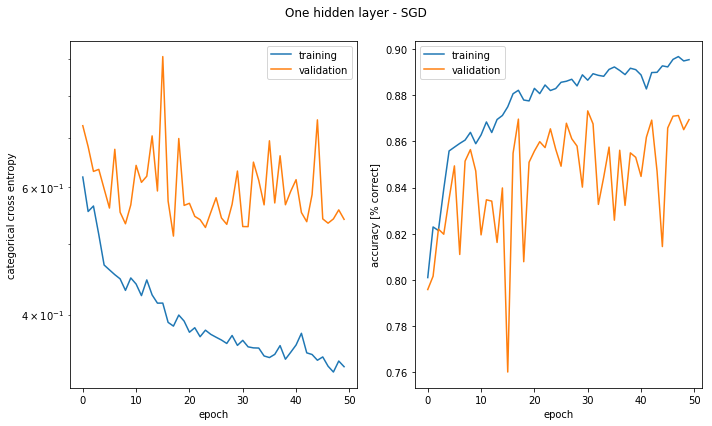

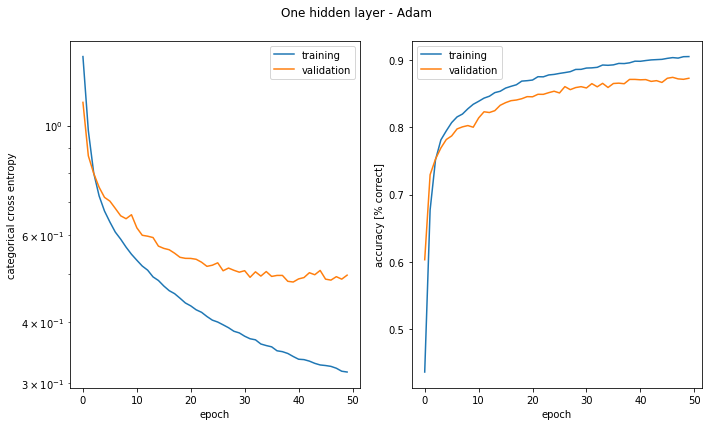

In [18]:
# histories[2] (lr=0.1) gives the best results
plot_history(histories[4], "One hidden layer - SGD")
plot_history(adam_history, "One hidden layer - Adam")
plt.show()

## Exercise 3: Overfitting and early stopping with Adam

### Description

Run the above simulation with Adam for sufficiently many epochs (be patient!) until you see clear overfitting.

1. Plot the learning curves of a fit with Adam and sufficiently many epochs and answer the questions below.

A simple, but effective mean to avoid overfitting is early stopping, i.e. a fit is not run until convergence but stopped as soon as the validation error starts to increase. We will use early stopping in all subsequent exercises.

### Solution

In [19]:
ex3_model = Sequential([
    Dense(64, input_shape=(256,), activation="relu"),
    Dense(5, activation="softmax"),
])

ex3_model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

ex3_history = ex3_model.fit(
    x_train, y_train, epochs=500, validation_data=(x_test,y_test), batch_size=128, verbose=1)

Train on 39523 samples, validate on 14002 samples
Epoch 1/500
39523/39523 [==============================] - 1s 22us/step - loss: 1.4193 - acc: 0.4027 - val_loss: 1.1720 - val_acc: 0.5901
Epoch 2/500
39523/39523 [==============================] - 1s 31us/step - loss: 1.0136 - acc: 0.6590 - val_loss: 0.9088 - val_acc: 0.7273
Epoch 3/500
39523/39523 [==============================] - 1s 18us/step - loss: 0.8162 - acc: 0.7475 - val_loss: 0.8070 - val_acc: 0.7495
Epoch 4/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.7286 - acc: 0.7775 - val_loss: 0.7681 - val_acc: 0.7565
Epoch 5/500
39523/39523 [==============================] - 2s 43us/step - loss: 0.6823 - acc: 0.7920 - val_loss: 0.7342 - val_acc: 0.7778
Epoch 6/500
39523/39523 [==============================] - 1s 18us/step - loss: 0.6436 - acc: 0.8037 - val_loss: 0.6982 - val_acc: 0.7890
Epoch 7/500
39523/39523 [==============================] - 1s 18us/step - loss: 0.6145 - acc: 0.8136 - val_loss: 0.6835 - 

39523/39523 [==============================] - 1s 18us/step - loss: 0.2951 - acc: 0.9108 - val_loss: 0.4821 - val_acc: 0.8763
Epoch 60/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.2948 - acc: 0.9119 - val_loss: 0.4840 - val_acc: 0.8761
Epoch 61/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.2959 - acc: 0.9104 - val_loss: 0.4743 - val_acc: 0.8786
Epoch 62/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.2959 - acc: 0.9117 - val_loss: 0.4774 - val_acc: 0.8789
Epoch 63/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.2941 - acc: 0.9109 - val_loss: 0.4663 - val_acc: 0.8793
Epoch 64/500
39523/39523 [==============================] - 2s 50us/step - loss: 0.2940 - acc: 0.9122 - val_loss: 0.4837 - val_acc: 0.8779
Epoch 65/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.2895 - acc: 0.9137 - val_loss: 0.4742 - val_acc: 0.8797
Epoch 66/500
39523/39523 [==============

Epoch 118/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.2359 - acc: 0.9276 - val_loss: 0.4980 - val_acc: 0.8853
Epoch 119/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.2320 - acc: 0.9280 - val_loss: 0.4960 - val_acc: 0.8849
Epoch 120/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.2341 - acc: 0.9278 - val_loss: 0.5044 - val_acc: 0.8801
Epoch 121/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.2303 - acc: 0.9295 - val_loss: 0.5018 - val_acc: 0.8820
Epoch 122/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.2296 - acc: 0.9300 - val_loss: 0.4954 - val_acc: 0.8835
Epoch 123/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.2308 - acc: 0.9284 - val_loss: 0.5047 - val_acc: 0.8809
Epoch 124/500
39523/39523 [==============================] - 1s 18us/step - loss: 0.2315 - acc: 0.9283 - val_loss: 0.5149 - val_acc: 0.8787
Epoch 125/500
39523/

39523/39523 [==============================] - 1s 17us/step - loss: 0.2024 - acc: 0.9373 - val_loss: 0.5363 - val_acc: 0.8792
Epoch 177/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2001 - acc: 0.9384 - val_loss: 0.5366 - val_acc: 0.8852
Epoch 178/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.1997 - acc: 0.9378 - val_loss: 0.5290 - val_acc: 0.8850
Epoch 179/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.2010 - acc: 0.9368 - val_loss: 0.5473 - val_acc: 0.8786
Epoch 180/500
39523/39523 [==============================] - 2s 43us/step - loss: 0.2000 - acc: 0.9383 - val_loss: 0.5452 - val_acc: 0.8785
Epoch 181/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.1969 - acc: 0.9393 - val_loss: 0.5325 - val_acc: 0.8839
Epoch 182/500
39523/39523 [==============================] - 1s 18us/step - loss: 0.1979 - acc: 0.9397 - val_loss: 0.5352 - val_acc: 0.8859
Epoch 183/500
39523/39523 [=======

39523/39523 [==============================] - 1s 17us/step - loss: 0.1783 - acc: 0.9440 - val_loss: 0.5668 - val_acc: 0.8842
Epoch 235/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.1813 - acc: 0.9438 - val_loss: 0.5700 - val_acc: 0.8799
Epoch 236/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.1811 - acc: 0.9437 - val_loss: 0.5565 - val_acc: 0.8864
Epoch 237/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.1802 - acc: 0.9428 - val_loss: 0.5524 - val_acc: 0.8859
Epoch 238/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.1772 - acc: 0.9453 - val_loss: 0.5576 - val_acc: 0.8854
Epoch 239/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.1756 - acc: 0.9454 - val_loss: 0.5559 - val_acc: 0.8868
Epoch 240/500
39523/39523 [==============================] - 2s 43us/step - loss: 0.1754 - acc: 0.9453 - val_loss: 0.5601 - val_acc: 0.8864
Epoch 241/500
39523/39523 [=======

39523/39523 [==============================] - 1s 17us/step - loss: 0.1621 - acc: 0.9491 - val_loss: 0.5920 - val_acc: 0.8799
Epoch 293/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.1648 - acc: 0.9486 - val_loss: 0.5918 - val_acc: 0.8803
Epoch 294/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.1647 - acc: 0.9489 - val_loss: 0.5967 - val_acc: 0.8836
Epoch 295/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.1647 - acc: 0.9477 - val_loss: 0.5927 - val_acc: 0.8837
Epoch 296/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.1673 - acc: 0.9467 - val_loss: 0.5863 - val_acc: 0.8843
Epoch 297/500
39523/39523 [==============================] - 1s 21us/step - loss: 0.1621 - acc: 0.9493 - val_loss: 0.5960 - val_acc: 0.8809
Epoch 298/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.1656 - acc: 0.9476 - val_loss: 0.5778 - val_acc: 0.8859
Epoch 299/500
39523/39523 [=======

39523/39523 [==============================] - 1s 17us/step - loss: 0.1526 - acc: 0.9520 - val_loss: 0.6147 - val_acc: 0.8834
Epoch 351/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.1559 - acc: 0.9515 - val_loss: 0.6117 - val_acc: 0.8842
Epoch 352/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.1517 - acc: 0.9520 - val_loss: 0.6112 - val_acc: 0.8849
Epoch 353/500
39523/39523 [==============================] - 2s 42us/step - loss: 0.1492 - acc: 0.9533 - val_loss: 0.6187 - val_acc: 0.8802
Epoch 354/500
39523/39523 [==============================] - 1s 18us/step - loss: 0.1524 - acc: 0.9517 - val_loss: 0.6170 - val_acc: 0.8839
Epoch 355/500
39523/39523 [==============================] - 1s 18us/step - loss: 0.1505 - acc: 0.9531 - val_loss: 0.6139 - val_acc: 0.8852
Epoch 356/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.1523 - acc: 0.9525 - val_loss: 0.6561 - val_acc: 0.8741
Epoch 357/500
39523/39523 [=======

39523/39523 [==============================] - 1s 17us/step - loss: 0.1455 - acc: 0.9536 - val_loss: 0.6316 - val_acc: 0.8850
Epoch 409/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.1408 - acc: 0.9556 - val_loss: 0.6374 - val_acc: 0.8831
Epoch 410/500
39523/39523 [==============================] - 1s 18us/step - loss: 0.1384 - acc: 0.9563 - val_loss: 0.6351 - val_acc: 0.8838
Epoch 411/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.1420 - acc: 0.9547 - val_loss: 0.6419 - val_acc: 0.8806
Epoch 412/500
39523/39523 [==============================] - 1s 18us/step - loss: 0.1427 - acc: 0.9550 - val_loss: 0.6534 - val_acc: 0.8825
Epoch 413/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.1412 - acc: 0.9559 - val_loss: 0.6392 - val_acc: 0.8852
Epoch 414/500
39523/39523 [==============================] - 2s 43us/step - loss: 0.1425 - acc: 0.9551 - val_loss: 0.6307 - val_acc: 0.8835
Epoch 415/500
39523/39523 [=======

39523/39523 [==============================] - 1s 17us/step - loss: 0.1316 - acc: 0.9588 - val_loss: 0.6616 - val_acc: 0.8837
Epoch 467/500
39523/39523 [==============================] - 1s 18us/step - loss: 0.1345 - acc: 0.9567 - val_loss: 0.6496 - val_acc: 0.8829
Epoch 468/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.1357 - acc: 0.9565 - val_loss: 0.6573 - val_acc: 0.8814
Epoch 469/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.1336 - acc: 0.9577 - val_loss: 0.6622 - val_acc: 0.8823
Epoch 470/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.1294 - acc: 0.9592 - val_loss: 0.6872 - val_acc: 0.8736
Epoch 471/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.1317 - acc: 0.9586 - val_loss: 0.6502 - val_acc: 0.8832
Epoch 472/500
39523/39523 [==============================] - 2s 44us/step - loss: 0.1318 - acc: 0.9590 - val_loss: 0.6609 - val_acc: 0.8810
Epoch 473/500
39523/39523 [=======

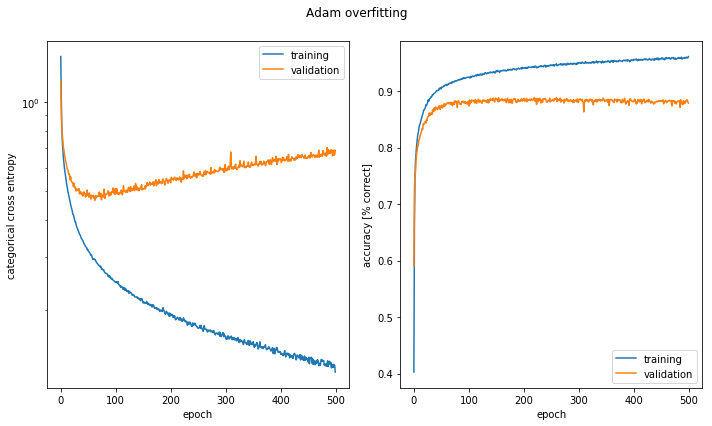

In [20]:
plot_history(ex3_history, "Adam overfitting")
plt.show()

**Question 1**: At which epoch (approximately) does the model start to overfit? Please answer with one full sentence.

**Answer**: It starts to overfit a bit before epoch 100, where we can see that the validation error goes up and accuracy goes down.

**Question 2**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**: For the loss curve, overfitting can be detected as a minimum after which the curve has a relevant positive slope. The difference between the validation set and the training set keep increasing as the traning loss goes to zero while the training loss keeps increasing. 
For the accuracy curve, after reaching overfitting, the accuracy of the validation set remains quite stable although it decreases at a low speed while the accuracy if the training set keeps increasing towards 100%.

## Exercise 4: Model performance as a function of number of hidden neurons

### Description

Investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models with different hidden layer size (between 10 and 1000 hidden neurons) for a fixed number of epochs well beyond the point of overfitting.
2. Collect some statistics by fitting the same models as in 1. for multiple initial conditions. Hints: 1. If you don't reset the random seed, you get different initial conditions each time you create a new model. 2. Let your computer work while you are asleep.
3. Plot summary statistics of the final validation loss and accuracy versus the number of hidden neurons. Hint: [boxplots](https://matplotlib.org/examples/pylab_examples/boxplot_demo.html) (also [here](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.boxplot.html?highlight=boxplot#matplotlib.axes.Axes.boxplot)) are useful. You may also want to use the matplotlib method set_xticklabels.
4. Plot summary statistics of the loss and accuracy for early stopping versus the number of hidden neurons.

### Solution

In [21]:
hidden_n = [10, 50, 100, 200, 300, 400, 500, 1000]

accuracy = {}
losses = {}

for params in hidden_n:
    print("Number of hidden units:", params)
    accuracy[params] = []
    losses[params] = []
    for n in range(5):
        print("Iteration number", n)
        model = Sequential([
            Dense(params, input_shape=(256,), activation='relu'),
            Dense(5, activation='softmax'),
        ])

        model.compile(optimizer=SGD(lr=0.1),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
        h = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=200,  batch_size=128, verbose=0)
        accuracy[params].append(h.history.get('val_acc')[-1]) 
        losses[params].append(h.history.get('val_loss')[-1])

Number of hidden units: 10
Iteration number 0
Iteration number 1
Iteration number 2
Iteration number 3
Iteration number 4
Number of hidden units: 50
Iteration number 0
Iteration number 1
Iteration number 2
Iteration number 3
Iteration number 4
Number of hidden units: 100
Iteration number 0
Iteration number 1
Iteration number 2
Iteration number 3
Iteration number 4
Number of hidden units: 200
Iteration number 0
Iteration number 1
Iteration number 2
Iteration number 3
Iteration number 4
Number of hidden units: 300
Iteration number 0
Iteration number 1
Iteration number 2
Iteration number 3
Iteration number 4
Number of hidden units: 400
Iteration number 0
Iteration number 1
Iteration number 2
Iteration number 3
Iteration number 4
Number of hidden units: 500
Iteration number 0
Iteration number 1
Iteration number 2
Iteration number 3
Iteration number 4
Number of hidden units: 1000
Iteration number 0
Iteration number 1
Iteration number 2
Iteration number 3
Iteration number 4


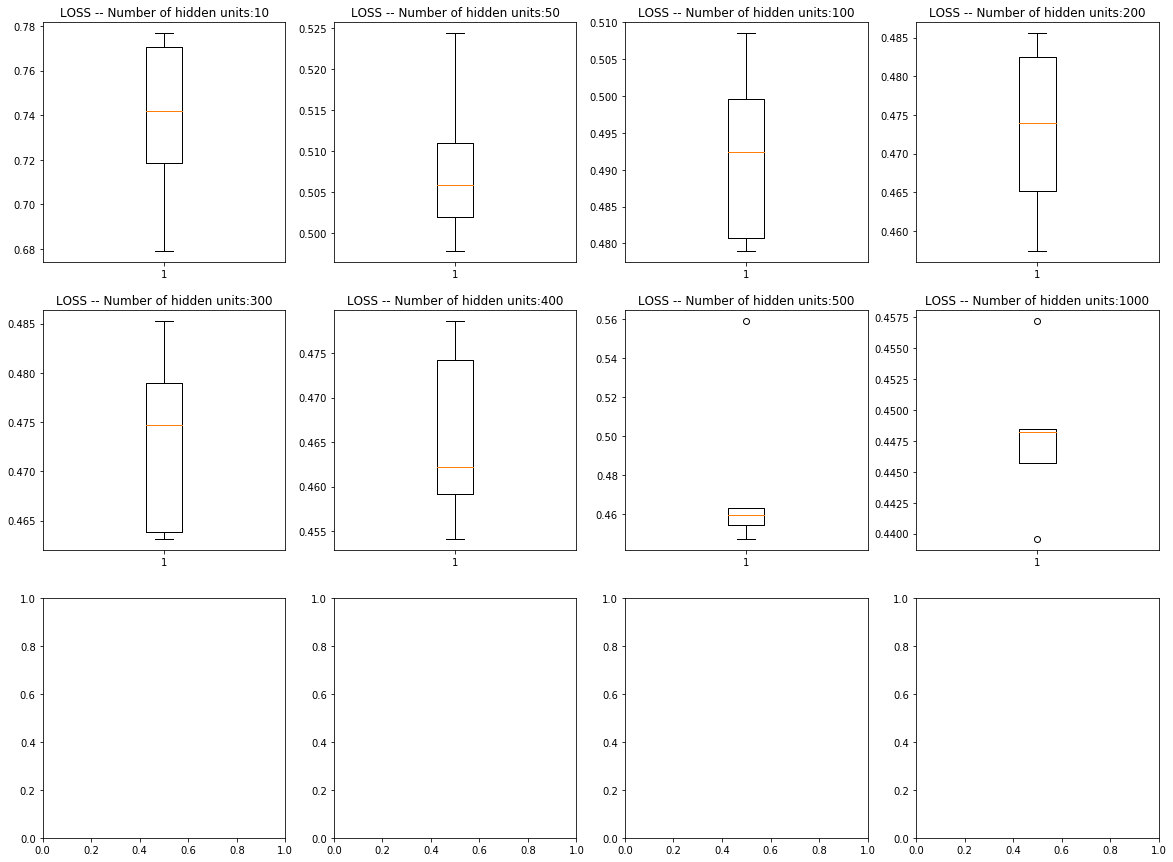

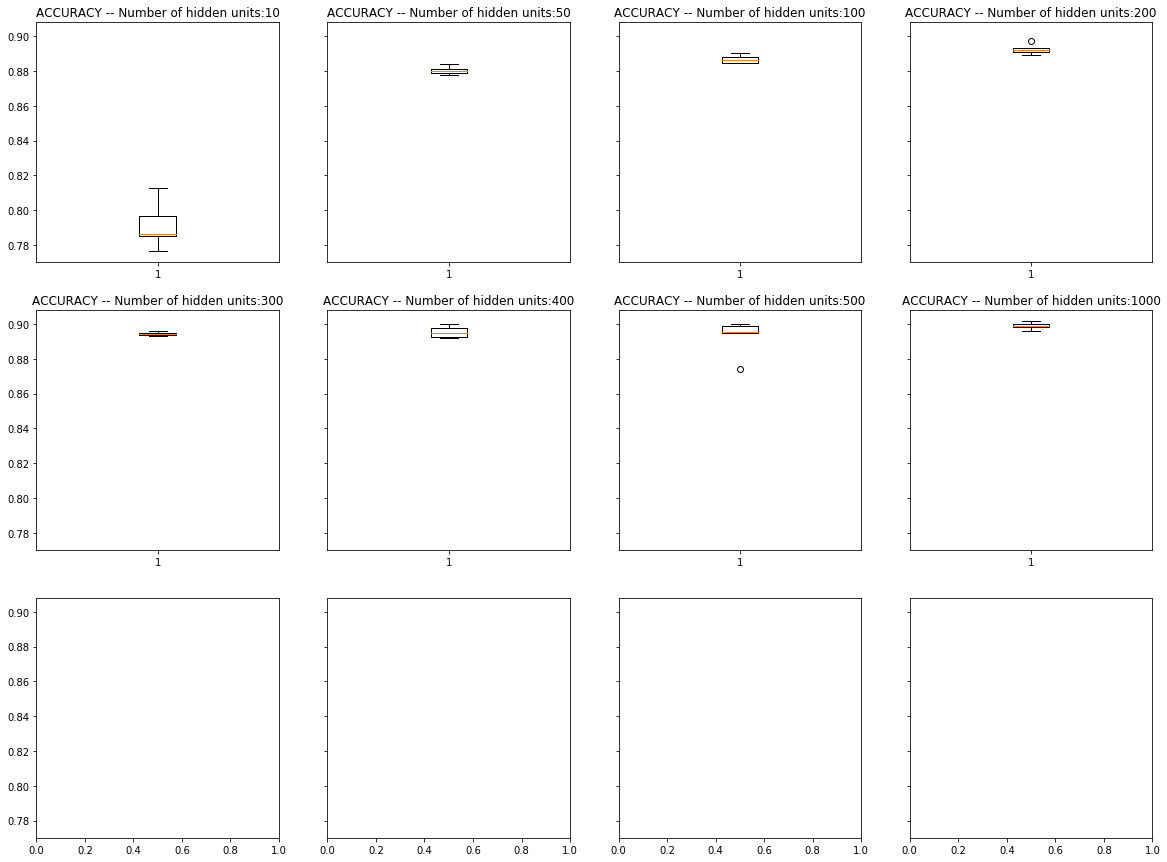

In [22]:
fig1, axes1 = plt.subplots(nrows=3, ncols=4, figsize=(20, 15), sharey=False)
fig2, axes2 = plt.subplots(nrows=3, ncols=4, figsize=(20, 15), sharey=True)
fs = 12
for n in range(len(hidden_n)):
    row = int(n/4)
    col = n%4
    data_loss = losses[hidden_n[n]]
    data_acc = accuracy[hidden_n[n]]
    
    axes1[row, col].boxplot(data_loss, manage_xticks=True)
    axes1[row, col].set_title('LOSS -- Number of hidden units:{}'.format(hidden_n[n]), fontsize=fs)
    
    axes2[row, col].boxplot(data_acc, manage_xticks=True)
    axes2[row, col].set_title('ACCURACY -- Number of hidden units:{}'.format(hidden_n[n]), fontsize=fs)
    
plt.show()

## Exercise 5: Comparison to deep models

### Description

Instead of choosing one hidden layer (with many neurons) you experiment here with multiple hidden layers (each with not so many neurons).

1. Fit models with 2, 3 and 4 hidden layers with approximately the same number of parameters as a network with one hidden layer of 100 neurons. Hint: Calculate the number of parameters in a network with input dimensionality N_in, K hidden layers with N_h units, one output layer with N_out dimensions and solve for N_h. Confirm you result with the keras method model.summary().
2. Run each model multiple times with different initial conditions and plot summary statistics of the best validation loss and accuracy versus the number of hidden layers.

### Solution

In [23]:
models = []
nh_2 = 77
nh_3 = 66
nh_4 = 59

models.append(Sequential([
    Dense(100, input_shape=(256,), activation='relu', kernel_initializer='random_uniform',
                bias_initializer='random_uniform'),
    Dense(5, activation='softmax')
]))

models.append(Sequential([
    Dense(nh_2, input_shape=(256,), activation='relu', kernel_initializer='random_uniform',
                bias_initializer='random_uniform'),
    Dense(nh_2, activation='relu'),
    Dense(5, activation='softmax')
]))

models.append(Sequential([
    Dense(nh_3, input_shape=(256,), activation='relu', kernel_initializer='random_uniform',
                bias_initializer='random_uniform'),
    Dense(nh_3, activation='relu'),
    Dense(nh_3, activation='relu'),
    Dense(5, activation='softmax')
]))

models.append(Sequential([
    Dense(nh_4, input_shape=(256,), activation='relu', kernel_initializer='random_uniform',
                bias_initializer='random_uniform'),
    Dense(nh_4, activation='relu'),
    Dense(nh_4, activation='relu'),
    Dense(nh_4, activation='relu'),
    Dense(5, activation='softmax')
]))

for model in models:
    model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_88 (Dense)             (None, 100)               25700     
_________________________________________________________________
dense_89 (Dense)             (None, 5)                 505       
Total params: 26,205
Trainable params: 26,205
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_90 (Dense)             (None, 77)                19789     
_________________________________________________________________
dense_91 (Dense)             (None, 77)                6006      
_________________________________________________________________
dense_92 (Dense)             (None, 5)                 390       
Total params: 26,185
Trainable params: 26,185
Non-trainable params: 0
__

In [24]:
accuracy = {}
losses = {}
histories = {}

for i, model in enumerate(models):
    print("Model", i)
    accuracy[model] = []
    losses[model] = []
    histories[model] = []
    for n in range(5):
        print("Iteration number {}".format(n))
        model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
        
        h = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=300,  batch_size=128, verbose=0)
        print('Test accuracy: {}'.format(h.history.get('val_acc')[-1]))
        accuracy[model].append(h.history.get('val_acc')[-1]) 
        print('Test loss: {}'.format(h.history.get('val_loss')[-1]))
        losses[model].append(h.history.get('val_loss')[-1])
        histories[model].append(h)

Model 0
Iteration number 0
Test accuracy: 0.8530209969663736
Test loss: 0.5195586665445286
Iteration number 1
Test accuracy: 0.8813740893136329
Test loss: 0.44416195461535823
Iteration number 2
Test accuracy: 0.8903013854227038
Test loss: 0.4323749870738716
Iteration number 3
Test accuracy: 0.8937294672700511
Test loss: 0.4371850038831395
Iteration number 4
Test accuracy: 0.8949435795397269
Test loss: 0.44706963610349426
Model 1
Iteration number 0
Test accuracy: 0.8825882015833088
Test loss: 0.42310876297858796
Iteration number 1
Test accuracy: 0.8879445793883765
Test loss: 0.4473378084469073
Iteration number 2
Test accuracy: 0.886444793575373
Test loss: 0.5224820738127531
Iteration number 3
Test accuracy: 0.8885159261940786
Test loss: 0.5818573512821228
Iteration number 4
Test accuracy: 0.8835166405225001
Test loss: 0.658066318897056
Model 2
Iteration number 0
Test accuracy: 0.8732323953380348
Test loss: 0.4801148276144463
Iteration number 1
Test accuracy: 0.8790887015800002
Test loss

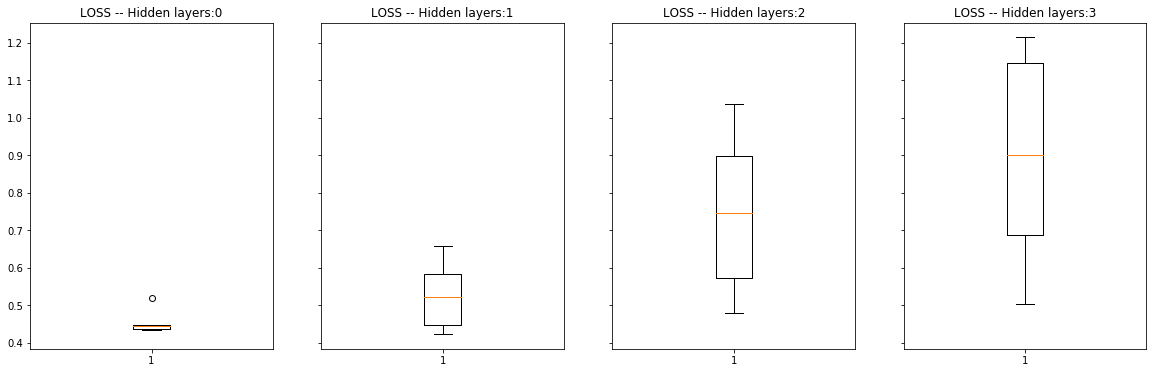

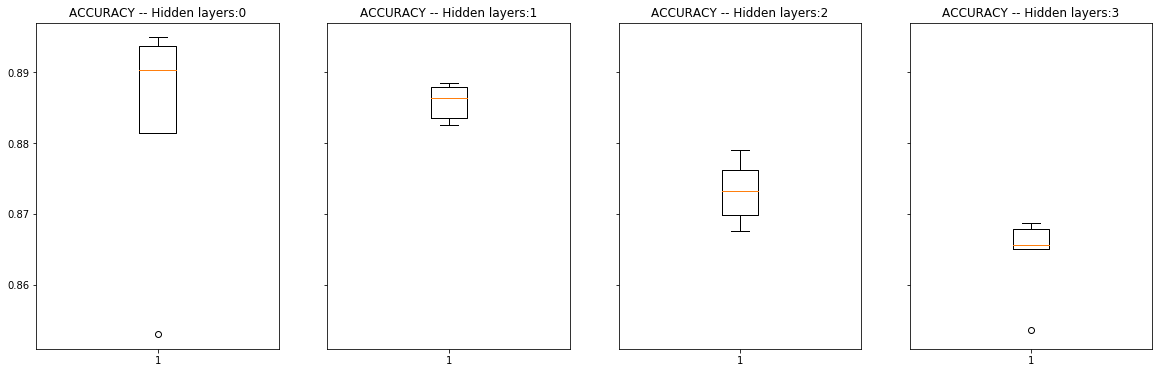

In [25]:
fig1, axes1 = plt.subplots(nrows=1, ncols=4, figsize=(20, 6), sharey=True)
fig2, axes2 = plt.subplots(nrows=1, ncols=4, figsize=(20, 6), sharey=True)
fs = 12

for n in range(len(models)):
    row = 0
    col = n%4

    data_loss = losses[models[n]]
    data_acc = accuracy[models[n]]
    
    axes1[col].boxplot(data_loss, manage_xticks=True)
    axes1[col].set_title('LOSS -- Hidden layers:{}'.format(n), fontsize=fs)
    
    axes2[col].boxplot(data_acc, manage_xticks=True)
    axes2[col].set_title('ACCURACY -- Hidden layers:{}'.format(n), fontsize=fs)
    
plt.show()

## Exercise 6: Tricks (regularization, batch normalization, dropout)

### Description

Overfitting can also be counteracted with regularization and dropout. Batch normalization is supposed to mainly decrease convergence time.

1. Try to improve the best validation scores of the model with 1 layer and 100 hidden neurons and the model with 4 hidden layers. Experiment with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases.
2. After you have found good settings, plot for both models the learning curves of the naive model you fitted in the previous exercises together with the learning curves of the current version.
3. For proper comparison, plot also the learning curves of the two current models in a third figure.

### Solution

In [26]:
model = Sequential([
    Dense(100, 
          input_shape=(256,), 
          activation='relu', 
          kernel_initializer='random_uniform', 
          bias_initializer='random_uniform',
          kernel_regularizer=regularizers.l2(0.0005),
          bias_regularizer=regularizers.l2(0.0005)),
    BatchNormalization(momentum=0.999),
    Dense(5, activation='softmax')
])
model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
h1 = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=500, batch_size=128, verbose=1)
print("Accuracy", h1.history.get('acc')[-1])
print("Val Accuracy", h1.history.get('val_acc')[-1])

Train on 39523 samples, validate on 14002 samples
Epoch 1/500
39523/39523 [==============================] - 2s 59us/step - loss: 1.1984 - acc: 0.5794 - val_loss: 0.9805 - val_acc: 0.6575
Epoch 2/500
39523/39523 [==============================] - 2s 48us/step - loss: 0.8647 - acc: 0.7341 - val_loss: 0.8414 - val_acc: 0.7245
Epoch 3/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.7545 - acc: 0.7707 - val_loss: 0.7614 - val_acc: 0.7605
Epoch 4/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.6952 - acc: 0.7898 - val_loss: 0.7489 - val_acc: 0.7610
Epoch 5/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.6549 - acc: 0.8039 - val_loss: 0.7086 - val_acc: 0.7717
Epoch 6/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.6261 - acc: 0.8121 - val_loss: 0.7024 - val_acc: 0.7702
Epoch 7/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.5981 - acc: 0.8228 - val_loss: 0.6471 - 

39523/39523 [==============================] - 2s 52us/step - loss: 0.3259 - acc: 0.9041 - val_loss: 0.5046 - val_acc: 0.8678
Epoch 60/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.3233 - acc: 0.9061 - val_loss: 0.5471 - val_acc: 0.8547
Epoch 61/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.3219 - acc: 0.9069 - val_loss: 0.5054 - val_acc: 0.8695
Epoch 62/500
39523/39523 [==============================] - 1s 27us/step - loss: 0.3230 - acc: 0.9068 - val_loss: 0.5073 - val_acc: 0.8672
Epoch 63/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.3195 - acc: 0.9078 - val_loss: 0.4942 - val_acc: 0.8745
Epoch 64/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.3212 - acc: 0.9051 - val_loss: 0.5039 - val_acc: 0.8673
Epoch 65/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.3176 - acc: 0.9073 - val_loss: 0.4997 - val_acc: 0.8696
Epoch 66/500
39523/39523 [==============

Epoch 118/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2776 - acc: 0.9197 - val_loss: 0.5232 - val_acc: 0.8744
Epoch 119/500
39523/39523 [==============================] - 2s 52us/step - loss: 0.2763 - acc: 0.9205 - val_loss: 0.5323 - val_acc: 0.8772
Epoch 120/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2802 - acc: 0.9185 - val_loss: 0.5314 - val_acc: 0.8681
Epoch 121/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2762 - acc: 0.9202 - val_loss: 0.5033 - val_acc: 0.8814
Epoch 122/500
39523/39523 [==============================] - 1s 27us/step - loss: 0.2742 - acc: 0.9214 - val_loss: 0.5469 - val_acc: 0.8722
Epoch 123/500
39523/39523 [==============================] - 2s 42us/step - loss: 0.2768 - acc: 0.9219 - val_loss: 0.5033 - val_acc: 0.8801
Epoch 124/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2775 - acc: 0.9206 - val_loss: 0.5226 - val_acc: 0.8748
Epoch 125/500
39523/

39523/39523 [==============================] - 1s 26us/step - loss: 0.2567 - acc: 0.9272 - val_loss: 0.5743 - val_acc: 0.8654
Epoch 177/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2603 - acc: 0.9273 - val_loss: 0.6290 - val_acc: 0.8551
Epoch 178/500
39523/39523 [==============================] - 2s 52us/step - loss: 0.2605 - acc: 0.9273 - val_loss: 0.5868 - val_acc: 0.8636
Epoch 179/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2550 - acc: 0.9269 - val_loss: 0.5536 - val_acc: 0.8750
Epoch 180/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2576 - acc: 0.9261 - val_loss: 0.5529 - val_acc: 0.8744
Epoch 181/500
39523/39523 [==============================] - 1s 30us/step - loss: 0.2603 - acc: 0.9259 - val_loss: 0.5632 - val_acc: 0.8676
Epoch 182/500
39523/39523 [==============================] - 2s 45us/step - loss: 0.2567 - acc: 0.9275 - val_loss: 0.6146 - val_acc: 0.8548
Epoch 183/500
39523/39523 [=======

39523/39523 [==============================] - 1s 26us/step - loss: 0.2452 - acc: 0.9315 - val_loss: 0.7560 - val_acc: 0.8367
Epoch 235/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2473 - acc: 0.9314 - val_loss: 0.5618 - val_acc: 0.8755
Epoch 236/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2430 - acc: 0.9315 - val_loss: 0.6323 - val_acc: 0.8569
Epoch 237/500
39523/39523 [==============================] - 1s 27us/step - loss: 0.2444 - acc: 0.9304 - val_loss: 0.5679 - val_acc: 0.8698
Epoch 238/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2427 - acc: 0.9314 - val_loss: 0.5524 - val_acc: 0.8787
Epoch 239/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2415 - acc: 0.9327 - val_loss: 0.5307 - val_acc: 0.8877
Epoch 240/500
39523/39523 [==============================] - 2s 53us/step - loss: 0.2395 - acc: 0.9352 - val_loss: 0.5511 - val_acc: 0.8813
Epoch 241/500
39523/39523 [=======

39523/39523 [==============================] - 1s 26us/step - loss: 0.2386 - acc: 0.9345 - val_loss: 0.5931 - val_acc: 0.8734
Epoch 293/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2335 - acc: 0.9357 - val_loss: 0.6611 - val_acc: 0.8503
Epoch 294/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2362 - acc: 0.9352 - val_loss: 0.6434 - val_acc: 0.8565
Epoch 295/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2343 - acc: 0.9346 - val_loss: 0.5822 - val_acc: 0.8762
Epoch 296/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2350 - acc: 0.9356 - val_loss: 0.6900 - val_acc: 0.8430
Epoch 297/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2354 - acc: 0.9353 - val_loss: 0.5912 - val_acc: 0.8762
Epoch 298/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2354 - acc: 0.9351 - val_loss: 0.6078 - val_acc: 0.8703
Epoch 299/500
39523/39523 [=======

39523/39523 [==============================] - 1s 27us/step - loss: 0.2326 - acc: 0.9376 - val_loss: 0.5857 - val_acc: 0.8790
Epoch 351/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2355 - acc: 0.9369 - val_loss: 0.6526 - val_acc: 0.8603
Epoch 352/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2363 - acc: 0.9353 - val_loss: 0.6284 - val_acc: 0.8635
Epoch 353/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2367 - acc: 0.9353 - val_loss: 0.6100 - val_acc: 0.8732
Epoch 354/500
39523/39523 [==============================] - 1s 27us/step - loss: 0.2272 - acc: 0.9373 - val_loss: 0.5677 - val_acc: 0.8807
Epoch 355/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2295 - acc: 0.9376 - val_loss: 0.6503 - val_acc: 0.8597
Epoch 356/500
39523/39523 [==============================] - 1s 27us/step - loss: 0.2348 - acc: 0.9373 - val_loss: 0.6270 - val_acc: 0.8687
Epoch 357/500
39523/39523 [=======

39523/39523 [==============================] - 1s 26us/step - loss: 0.2418 - acc: 0.9343 - val_loss: 0.6828 - val_acc: 0.8545
Epoch 409/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2377 - acc: 0.9344 - val_loss: 0.6877 - val_acc: 0.8507
Epoch 410/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2336 - acc: 0.9371 - val_loss: 0.7695 - val_acc: 0.8345
Epoch 411/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2372 - acc: 0.9376 - val_loss: 0.8333 - val_acc: 0.8267
Epoch 412/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2363 - acc: 0.9365 - val_loss: 0.6601 - val_acc: 0.8624
Epoch 413/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2341 - acc: 0.9371 - val_loss: 0.6013 - val_acc: 0.8800
Epoch 414/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2391 - acc: 0.9347 - val_loss: 0.6997 - val_acc: 0.8511
Epoch 415/500
39523/39523 [=======

39523/39523 [==============================] - 1s 26us/step - loss: 0.2363 - acc: 0.9377 - val_loss: 0.6082 - val_acc: 0.8766
Epoch 467/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2261 - acc: 0.9398 - val_loss: 0.6291 - val_acc: 0.8672
Epoch 468/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2299 - acc: 0.9380 - val_loss: 0.6925 - val_acc: 0.8569
Epoch 469/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2248 - acc: 0.9401 - val_loss: 0.6045 - val_acc: 0.8821
Epoch 470/500
39523/39523 [==============================] - 1s 27us/step - loss: 0.2300 - acc: 0.9393 - val_loss: 1.1833 - val_acc: 0.7456
Epoch 471/500
39523/39523 [==============================] - 1s 27us/step - loss: 0.2266 - acc: 0.9399 - val_loss: 0.6336 - val_acc: 0.8730
Epoch 472/500
39523/39523 [==============================] - 2s 43us/step - loss: 0.2328 - acc: 0.9373 - val_loss: 0.8426 - val_acc: 0.8183
Epoch 473/500
39523/39523 [=======

In [27]:
model = Sequential([
    Dense(100, 
          input_shape=(256,), 
          activation='relu', 
          kernel_initializer='random_uniform', 
          bias_initializer='random_uniform'),
    Dense(5, activation='softmax')
])
model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
h2 = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=500, batch_size=128, verbose=1)
print("Accuracy", h2.history.get('acc')[-1])
print("Val Accuracy", h2.history.get('val_acc')[-1])

Train on 39523 samples, validate on 14002 samples
Epoch 1/500
39523/39523 [==============================] - 2s 52us/step - loss: 1.5502 - acc: 0.3487 - val_loss: 1.5316 - val_acc: 0.3642
Epoch 2/500
39523/39523 [==============================] - 1s 19us/step - loss: 1.5342 - acc: 0.3508 - val_loss: 1.5189 - val_acc: 0.3650
Epoch 3/500
39523/39523 [==============================] - 1s 19us/step - loss: 1.5245 - acc: 0.3515 - val_loss: 1.5084 - val_acc: 0.3687
Epoch 4/500
39523/39523 [==============================] - 1s 19us/step - loss: 1.5156 - acc: 0.3536 - val_loss: 1.4972 - val_acc: 0.3707
Epoch 5/500
39523/39523 [==============================] - 1s 34us/step - loss: 1.5059 - acc: 0.3557 - val_loss: 1.4868 - val_acc: 0.3799
Epoch 6/500
39523/39523 [==============================] - 1s 21us/step - loss: 1.4955 - acc: 0.3601 - val_loss: 1.4743 - val_acc: 0.3848
Epoch 7/500
39523/39523 [==============================] - 1s 19us/step - loss: 1.4836 - acc: 0.3650 - val_loss: 1.4609 - 

39523/39523 [==============================] - 1s 19us/step - loss: 0.7314 - acc: 0.7766 - val_loss: 0.7917 - val_acc: 0.7521
Epoch 60/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.7268 - acc: 0.7786 - val_loss: 0.7909 - val_acc: 0.7545
Epoch 61/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.7222 - acc: 0.7808 - val_loss: 0.7863 - val_acc: 0.7547
Epoch 62/500
39523/39523 [==============================] - 1s 18us/step - loss: 0.7181 - acc: 0.7824 - val_loss: 0.7816 - val_acc: 0.7563
Epoch 63/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.7138 - acc: 0.7837 - val_loss: 0.7803 - val_acc: 0.7578
Epoch 64/500
39523/39523 [==============================] - 1s 18us/step - loss: 0.7097 - acc: 0.7845 - val_loss: 0.7740 - val_acc: 0.7590
Epoch 65/500
39523/39523 [==============================] - 1s 18us/step - loss: 0.7058 - acc: 0.7859 - val_loss: 0.7719 - val_acc: 0.7592
Epoch 66/500
39523/39523 [==============

Epoch 118/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.5806 - acc: 0.8266 - val_loss: 0.6695 - val_acc: 0.7957
Epoch 119/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.5789 - acc: 0.8272 - val_loss: 0.6675 - val_acc: 0.7928
Epoch 120/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.5774 - acc: 0.8274 - val_loss: 0.6692 - val_acc: 0.7946
Epoch 121/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.5762 - acc: 0.8273 - val_loss: 0.6638 - val_acc: 0.7951
Epoch 122/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.5747 - acc: 0.8276 - val_loss: 0.6641 - val_acc: 0.7954
Epoch 123/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.5731 - acc: 0.8289 - val_loss: 0.6624 - val_acc: 0.7967
Epoch 124/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.5719 - acc: 0.8291 - val_loss: 0.6623 - val_acc: 0.7973
Epoch 125/500
39523/

39523/39523 [==============================] - 1s 19us/step - loss: 0.5101 - acc: 0.8480 - val_loss: 0.6053 - val_acc: 0.8192
Epoch 177/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.5086 - acc: 0.8481 - val_loss: 0.6081 - val_acc: 0.8165
Epoch 178/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.5080 - acc: 0.8486 - val_loss: 0.6067 - val_acc: 0.8200
Epoch 179/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.5070 - acc: 0.8486 - val_loss: 0.6045 - val_acc: 0.8197
Epoch 180/500
39523/39523 [==============================] - 2s 44us/step - loss: 0.5059 - acc: 0.8496 - val_loss: 0.6034 - val_acc: 0.8188
Epoch 181/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.5046 - acc: 0.8490 - val_loss: 0.6031 - val_acc: 0.8197
Epoch 182/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.5038 - acc: 0.8492 - val_loss: 0.6021 - val_acc: 0.8197
Epoch 183/500
39523/39523 [=======

39523/39523 [==============================] - 1s 20us/step - loss: 0.4563 - acc: 0.8657 - val_loss: 0.5600 - val_acc: 0.8391
Epoch 235/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.4555 - acc: 0.8653 - val_loss: 0.5585 - val_acc: 0.8383
Epoch 236/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.4544 - acc: 0.8661 - val_loss: 0.5584 - val_acc: 0.8397
Epoch 237/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.4540 - acc: 0.8657 - val_loss: 0.5577 - val_acc: 0.8392
Epoch 238/500
39523/39523 [==============================] - 1s 21us/step - loss: 0.4531 - acc: 0.8665 - val_loss: 0.5576 - val_acc: 0.8377
Epoch 239/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.4523 - acc: 0.8670 - val_loss: 0.5555 - val_acc: 0.8391
Epoch 240/500
39523/39523 [==============================] - 1s 18us/step - loss: 0.4517 - acc: 0.8676 - val_loss: 0.5534 - val_acc: 0.8407
Epoch 241/500
39523/39523 [=======

39523/39523 [==============================] - 1s 19us/step - loss: 0.4138 - acc: 0.8803 - val_loss: 0.5242 - val_acc: 0.8503
Epoch 293/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.4133 - acc: 0.8789 - val_loss: 0.5238 - val_acc: 0.8485
Epoch 294/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.4125 - acc: 0.8801 - val_loss: 0.5206 - val_acc: 0.8516
Epoch 295/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.4117 - acc: 0.8800 - val_loss: 0.5236 - val_acc: 0.8526
Epoch 296/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.4114 - acc: 0.8804 - val_loss: 0.5217 - val_acc: 0.8519
Epoch 297/500
39523/39523 [==============================] - 1s 21us/step - loss: 0.4107 - acc: 0.8798 - val_loss: 0.5197 - val_acc: 0.8541
Epoch 298/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.4098 - acc: 0.8806 - val_loss: 0.5186 - val_acc: 0.8519
Epoch 299/500
39523/39523 [=======

39523/39523 [==============================] - 1s 19us/step - loss: 0.3807 - acc: 0.8892 - val_loss: 0.4946 - val_acc: 0.8634
Epoch 351/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.3797 - acc: 0.8902 - val_loss: 0.4966 - val_acc: 0.8594
Epoch 352/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.3793 - acc: 0.8900 - val_loss: 0.4921 - val_acc: 0.8634
Epoch 353/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.3789 - acc: 0.8898 - val_loss: 0.4931 - val_acc: 0.8637
Epoch 354/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.3785 - acc: 0.8901 - val_loss: 0.4914 - val_acc: 0.8641
Epoch 355/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.3777 - acc: 0.8897 - val_loss: 0.4908 - val_acc: 0.8644
Epoch 356/500
39523/39523 [==============================] - 1s 18us/step - loss: 0.3773 - acc: 0.8898 - val_loss: 0.4903 - val_acc: 0.8617
Epoch 357/500
39523/39523 [=======

39523/39523 [==============================] - 1s 19us/step - loss: 0.3542 - acc: 0.8960 - val_loss: 0.4772 - val_acc: 0.8710
Epoch 409/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.3536 - acc: 0.8979 - val_loss: 0.4823 - val_acc: 0.8689
Epoch 410/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.3532 - acc: 0.8973 - val_loss: 0.4733 - val_acc: 0.8707
Epoch 411/500
39523/39523 [==============================] - 1s 32us/step - loss: 0.3527 - acc: 0.8975 - val_loss: 0.4769 - val_acc: 0.8709
Epoch 412/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.3525 - acc: 0.8982 - val_loss: 0.4733 - val_acc: 0.8689
Epoch 413/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.3521 - acc: 0.8975 - val_loss: 0.4727 - val_acc: 0.8699
Epoch 414/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.3518 - acc: 0.8976 - val_loss: 0.4723 - val_acc: 0.8706
Epoch 415/500
39523/39523 [=======

39523/39523 [==============================] - 1s 19us/step - loss: 0.3328 - acc: 0.9035 - val_loss: 0.4612 - val_acc: 0.8741
Epoch 467/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.3324 - acc: 0.9034 - val_loss: 0.4641 - val_acc: 0.8747
Epoch 468/500
39523/39523 [==============================] - 2s 41us/step - loss: 0.3319 - acc: 0.9035 - val_loss: 0.4619 - val_acc: 0.8754
Epoch 469/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.3317 - acc: 0.9037 - val_loss: 0.4592 - val_acc: 0.8750
Epoch 470/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.3310 - acc: 0.9039 - val_loss: 0.4595 - val_acc: 0.8750
Epoch 471/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.3309 - acc: 0.9046 - val_loss: 0.4630 - val_acc: 0.8751
Epoch 472/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.3305 - acc: 0.9038 - val_loss: 0.4595 - val_acc: 0.8739
Epoch 473/500
39523/39523 [=======

In [28]:
model = Sequential([
    Dense(100, 
          input_shape=(256,), 
          activation='relu', 
          kernel_initializer='random_uniform', 
          bias_initializer='random_uniform'),
    BatchNormalization(momentum=0.999),
    Dense(5, activation='softmax')
])
model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
h3 = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=500, batch_size=128, verbose=1)
print("Accuracy", h3.history.get('acc')[-1])
print("Val Accuracy", h3.history.get('val_acc')[-1])

Train on 39523 samples, validate on 14002 samples
Epoch 1/500
39523/39523 [==============================] - 3s 64us/step - loss: 1.2331 - acc: 0.5552 - val_loss: 1.0189 - val_acc: 0.6665
Epoch 2/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.8889 - acc: 0.7215 - val_loss: 0.8519 - val_acc: 0.7263
Epoch 3/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.7674 - acc: 0.7658 - val_loss: 0.7651 - val_acc: 0.7481
Epoch 4/500
39523/39523 [==============================] - 1s 27us/step - loss: 0.7032 - acc: 0.7865 - val_loss: 0.7383 - val_acc: 0.7736
Epoch 5/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.6598 - acc: 0.7996 - val_loss: 0.7457 - val_acc: 0.7510
Epoch 6/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.6245 - acc: 0.8108 - val_loss: 0.7269 - val_acc: 0.7665
Epoch 7/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.6004 - acc: 0.8171 - val_loss: 0.6472 - 

39523/39523 [==============================] - 1s 29us/step - loss: 0.3023 - acc: 0.9078 - val_loss: 0.4803 - val_acc: 0.8694
Epoch 60/500
39523/39523 [==============================] - 1s 27us/step - loss: 0.3038 - acc: 0.9048 - val_loss: 0.5408 - val_acc: 0.8496
Epoch 61/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2986 - acc: 0.9089 - val_loss: 0.4683 - val_acc: 0.8729
Epoch 62/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2990 - acc: 0.9072 - val_loss: 0.4547 - val_acc: 0.8823
Epoch 63/500
39523/39523 [==============================] - 1s 27us/step - loss: 0.2984 - acc: 0.9070 - val_loss: 0.4956 - val_acc: 0.8697
Epoch 64/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2955 - acc: 0.9082 - val_loss: 0.4613 - val_acc: 0.8764
Epoch 65/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2905 - acc: 0.9124 - val_loss: 0.5022 - val_acc: 0.8674
Epoch 66/500
39523/39523 [==============

Epoch 118/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2383 - acc: 0.9248 - val_loss: 0.4732 - val_acc: 0.8811
Epoch 119/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2431 - acc: 0.9230 - val_loss: 0.5869 - val_acc: 0.8439
Epoch 120/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2419 - acc: 0.9230 - val_loss: 0.4728 - val_acc: 0.8822
Epoch 121/500
39523/39523 [==============================] - 1s 27us/step - loss: 0.2386 - acc: 0.9240 - val_loss: 0.5327 - val_acc: 0.8626
Epoch 122/500
39523/39523 [==============================] - 1s 33us/step - loss: 0.2360 - acc: 0.9255 - val_loss: 0.4937 - val_acc: 0.8757
Epoch 123/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2358 - acc: 0.9255 - val_loss: 0.5157 - val_acc: 0.8649
Epoch 124/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2356 - acc: 0.9257 - val_loss: 0.5123 - val_acc: 0.8717
Epoch 125/500
39523/

39523/39523 [==============================] - 1s 26us/step - loss: 0.2085 - acc: 0.9323 - val_loss: 0.5153 - val_acc: 0.8736
Epoch 177/500
39523/39523 [==============================] - 1s 27us/step - loss: 0.2074 - acc: 0.9315 - val_loss: 0.5172 - val_acc: 0.8740
Epoch 178/500
39523/39523 [==============================] - 1s 27us/step - loss: 0.2082 - acc: 0.9328 - val_loss: 0.5919 - val_acc: 0.8582
Epoch 179/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.2080 - acc: 0.9329 - val_loss: 0.4782 - val_acc: 0.8859
Epoch 180/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2059 - acc: 0.9338 - val_loss: 0.4889 - val_acc: 0.8880
Epoch 181/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2071 - acc: 0.9335 - val_loss: 0.4972 - val_acc: 0.8869
Epoch 182/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2037 - acc: 0.9349 - val_loss: 0.5433 - val_acc: 0.8717
Epoch 183/500
39523/39523 [=======

39523/39523 [==============================] - 1s 27us/step - loss: 0.1863 - acc: 0.9387 - val_loss: 0.5147 - val_acc: 0.8863
Epoch 235/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.1818 - acc: 0.9420 - val_loss: 0.5381 - val_acc: 0.8764
Epoch 236/500
39523/39523 [==============================] - 1s 27us/step - loss: 0.1837 - acc: 0.9411 - val_loss: 0.5072 - val_acc: 0.8854
Epoch 237/500
39523/39523 [==============================] - 1s 27us/step - loss: 0.1847 - acc: 0.9394 - val_loss: 0.5160 - val_acc: 0.8874
Epoch 238/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.1813 - acc: 0.9404 - val_loss: 0.5170 - val_acc: 0.8852
Epoch 239/500
39523/39523 [==============================] - 1s 27us/step - loss: 0.1805 - acc: 0.9412 - val_loss: 0.5186 - val_acc: 0.8846
Epoch 240/500
39523/39523 [==============================] - 2s 46us/step - loss: 0.1814 - acc: 0.9413 - val_loss: 0.5063 - val_acc: 0.8879
Epoch 241/500
39523/39523 [=======

39523/39523 [==============================] - 1s 26us/step - loss: 0.1689 - acc: 0.9443 - val_loss: 0.5503 - val_acc: 0.8779
Epoch 293/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.1705 - acc: 0.9440 - val_loss: 0.5543 - val_acc: 0.8806
Epoch 294/500
39523/39523 [==============================] - 1s 27us/step - loss: 0.1682 - acc: 0.9442 - val_loss: 0.5547 - val_acc: 0.8802
Epoch 295/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.1744 - acc: 0.9422 - val_loss: 0.5657 - val_acc: 0.8772
Epoch 296/500
39523/39523 [==============================] - 1s 27us/step - loss: 0.1662 - acc: 0.9453 - val_loss: 0.5375 - val_acc: 0.8852
Epoch 297/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.1672 - acc: 0.9451 - val_loss: 0.5945 - val_acc: 0.8672
Epoch 298/500
39523/39523 [==============================] - 1s 27us/step - loss: 0.1676 - acc: 0.9455 - val_loss: 0.5775 - val_acc: 0.8798
Epoch 299/500
39523/39523 [=======

39523/39523 [==============================] - 1s 26us/step - loss: 0.1556 - acc: 0.9480 - val_loss: 0.5641 - val_acc: 0.8818
Epoch 351/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.1573 - acc: 0.9475 - val_loss: 0.5506 - val_acc: 0.8856
Epoch 352/500
39523/39523 [==============================] - 2s 39us/step - loss: 0.1563 - acc: 0.9488 - val_loss: 0.5847 - val_acc: 0.8832
Epoch 353/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.1537 - acc: 0.9492 - val_loss: 0.5664 - val_acc: 0.8812
Epoch 354/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.1563 - acc: 0.9481 - val_loss: 0.5504 - val_acc: 0.8846
Epoch 355/500
39523/39523 [==============================] - 1s 27us/step - loss: 0.1585 - acc: 0.9458 - val_loss: 0.5590 - val_acc: 0.8859
Epoch 356/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.1600 - acc: 0.9473 - val_loss: 0.5648 - val_acc: 0.8835
Epoch 357/500
39523/39523 [=======

39523/39523 [==============================] - 1s 27us/step - loss: 0.1512 - acc: 0.9492 - val_loss: 0.5750 - val_acc: 0.8815
Epoch 409/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.1439 - acc: 0.9527 - val_loss: 0.6171 - val_acc: 0.8768
Epoch 410/500
39523/39523 [==============================] - 1s 27us/step - loss: 0.1475 - acc: 0.9516 - val_loss: 0.6036 - val_acc: 0.8797
Epoch 411/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.1525 - acc: 0.9500 - val_loss: 0.6170 - val_acc: 0.8751
Epoch 412/500
39523/39523 [==============================] - 1s 27us/step - loss: 0.1448 - acc: 0.9529 - val_loss: 0.5662 - val_acc: 0.8842
Epoch 413/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.1460 - acc: 0.9507 - val_loss: 0.5810 - val_acc: 0.8809
Epoch 414/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.1475 - acc: 0.9515 - val_loss: 0.5550 - val_acc: 0.8883
Epoch 415/500
39523/39523 [=======

39523/39523 [==============================] - 1s 26us/step - loss: 0.1401 - acc: 0.9543 - val_loss: 0.6102 - val_acc: 0.8813
Epoch 467/500
39523/39523 [==============================] - 1s 27us/step - loss: 0.1381 - acc: 0.9537 - val_loss: 0.5620 - val_acc: 0.8878
Epoch 468/500
39523/39523 [==============================] - 1s 27us/step - loss: 0.1410 - acc: 0.9531 - val_loss: 0.5770 - val_acc: 0.8862
Epoch 469/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.1355 - acc: 0.9547 - val_loss: 0.6087 - val_acc: 0.8824
Epoch 470/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.1354 - acc: 0.9555 - val_loss: 0.5836 - val_acc: 0.8841
Epoch 471/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.1417 - acc: 0.9531 - val_loss: 0.5847 - val_acc: 0.8858
Epoch 472/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.1390 - acc: 0.9547 - val_loss: 0.5673 - val_acc: 0.8891
Epoch 473/500
39523/39523 [=======

In [29]:
model = Sequential([
    Dense(100, 
          input_shape=(256,), 
          activation='relu', 
          kernel_initializer='random_uniform', 
          bias_initializer='random_uniform',
          kernel_regularizer=regularizers.l2(0.0005),
          bias_regularizer=regularizers.l2(0.0005)),
    BatchNormalization(momentum=0.999),
    Dropout(0.5),
    Dense(5, activation='softmax')
])
model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
h4 = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=500, batch_size=128, verbose=1)
print("Accuracy", h4.history.get('acc')[-1])
print("Val Accuracy", h4.history.get('val_acc')[-1])

Train on 39523 samples, validate on 14002 samples
Epoch 1/500
39523/39523 [==============================] - 3s 70us/step - loss: 1.4865 - acc: 0.3983 - val_loss: 1.1473 - val_acc: 0.6136
Epoch 2/500
39523/39523 [==============================] - 1s 29us/step - loss: 1.1162 - acc: 0.5886 - val_loss: 0.9277 - val_acc: 0.6797
Epoch 3/500
39523/39523 [==============================] - 1s 29us/step - loss: 0.9866 - acc: 0.6501 - val_loss: 0.8556 - val_acc: 0.7208
Epoch 4/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.9206 - acc: 0.6785 - val_loss: 0.8121 - val_acc: 0.7444
Epoch 5/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.8770 - acc: 0.6968 - val_loss: 0.7777 - val_acc: 0.7496
Epoch 6/500
39523/39523 [==============================] - 1s 29us/step - loss: 0.8518 - acc: 0.7104 - val_loss: 0.7596 - val_acc: 0.7613
Epoch 7/500
39523/39523 [==============================] - 2s 54us/step - loss: 0.8235 - acc: 0.7236 - val_loss: 0.7343 - 

39523/39523 [==============================] - 1s 28us/step - loss: 0.5983 - acc: 0.8095 - val_loss: 0.5423 - val_acc: 0.8430
Epoch 60/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.5983 - acc: 0.8126 - val_loss: 0.5527 - val_acc: 0.8479
Epoch 61/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.5923 - acc: 0.8121 - val_loss: 0.5322 - val_acc: 0.8477
Epoch 62/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.5913 - acc: 0.8111 - val_loss: 0.5491 - val_acc: 0.8494
Epoch 63/500
39523/39523 [==============================] - 2s 46us/step - loss: 0.5952 - acc: 0.8115 - val_loss: 0.5323 - val_acc: 0.8522
Epoch 64/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.5879 - acc: 0.8147 - val_loss: 0.5221 - val_acc: 0.8552
Epoch 65/500
39523/39523 [==============================] - 2s 54us/step - loss: 0.5895 - acc: 0.8132 - val_loss: 0.5369 - val_acc: 0.8542
Epoch 66/500
39523/39523 [==============

Epoch 118/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.5590 - acc: 0.8261 - val_loss: 0.5183 - val_acc: 0.8589
Epoch 119/500
39523/39523 [==============================] - 1s 29us/step - loss: 0.5611 - acc: 0.8230 - val_loss: 0.5366 - val_acc: 0.8599
Epoch 120/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.5542 - acc: 0.8262 - val_loss: 0.5103 - val_acc: 0.8589
Epoch 121/500
39523/39523 [==============================] - 2s 54us/step - loss: 0.5565 - acc: 0.8273 - val_loss: 0.5068 - val_acc: 0.8662
Epoch 122/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.5550 - acc: 0.8286 - val_loss: 0.5069 - val_acc: 0.8627
Epoch 123/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.5578 - acc: 0.8275 - val_loss: 0.4886 - val_acc: 0.8691
Epoch 124/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.5541 - acc: 0.8294 - val_loss: 0.5001 - val_acc: 0.8695
Epoch 125/500
39523/

39523/39523 [==============================] - 1s 28us/step - loss: 0.5420 - acc: 0.8334 - val_loss: 0.4978 - val_acc: 0.8722
Epoch 177/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.5385 - acc: 0.8361 - val_loss: 0.4971 - val_acc: 0.8711
Epoch 178/500
39523/39523 [==============================] - 1s 38us/step - loss: 0.5321 - acc: 0.8360 - val_loss: 0.4947 - val_acc: 0.8738
Epoch 179/500
39523/39523 [==============================] - 1s 29us/step - loss: 0.5294 - acc: 0.8367 - val_loss: 0.4968 - val_acc: 0.8733
Epoch 180/500
39523/39523 [==============================] - 2s 44us/step - loss: 0.5343 - acc: 0.8359 - val_loss: 0.5057 - val_acc: 0.8680
Epoch 181/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.5356 - acc: 0.8355 - val_loss: 0.5012 - val_acc: 0.8618
Epoch 182/500
39523/39523 [==============================] - 1s 29us/step - loss: 0.5343 - acc: 0.8363 - val_loss: 0.5226 - val_acc: 0.8647
Epoch 183/500
39523/39523 [=======

39523/39523 [==============================] - 1s 28us/step - loss: 0.5184 - acc: 0.8429 - val_loss: 0.4964 - val_acc: 0.8705
Epoch 235/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.5238 - acc: 0.8412 - val_loss: 0.5107 - val_acc: 0.8624
Epoch 236/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.5212 - acc: 0.8395 - val_loss: 0.5072 - val_acc: 0.8612
Epoch 237/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.5218 - acc: 0.8417 - val_loss: 0.5197 - val_acc: 0.8686
Epoch 238/500
39523/39523 [==============================] - 1s 29us/step - loss: 0.5194 - acc: 0.8437 - val_loss: 0.4910 - val_acc: 0.8727
Epoch 239/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.5212 - acc: 0.8428 - val_loss: 0.5088 - val_acc: 0.8677
Epoch 240/500
39523/39523 [==============================] - 1s 37us/step - loss: 0.5175 - acc: 0.8427 - val_loss: 0.5008 - val_acc: 0.8723
Epoch 241/500
39523/39523 [=======

39523/39523 [==============================] - 1s 28us/step - loss: 0.5066 - acc: 0.8468 - val_loss: 0.4969 - val_acc: 0.8745
Epoch 293/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.5164 - acc: 0.8450 - val_loss: 0.4947 - val_acc: 0.8746
Epoch 294/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.5094 - acc: 0.8462 - val_loss: 0.5181 - val_acc: 0.8689
Epoch 295/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.5127 - acc: 0.8445 - val_loss: 0.4993 - val_acc: 0.8727
Epoch 296/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.5113 - acc: 0.8444 - val_loss: 0.5027 - val_acc: 0.8735
Epoch 297/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.5117 - acc: 0.8441 - val_loss: 0.5037 - val_acc: 0.8704
Epoch 298/500
39523/39523 [==============================] - 1s 29us/step - loss: 0.5112 - acc: 0.8470 - val_loss: 0.4966 - val_acc: 0.8727
Epoch 299/500
39523/39523 [=======

39523/39523 [==============================] - 1s 28us/step - loss: 0.5038 - acc: 0.8488 - val_loss: 0.4992 - val_acc: 0.8728
Epoch 351/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.5047 - acc: 0.8485 - val_loss: 0.5032 - val_acc: 0.8715
Epoch 352/500
39523/39523 [==============================] - 1s 32us/step - loss: 0.5096 - acc: 0.8467 - val_loss: 0.5364 - val_acc: 0.8624
Epoch 353/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.5096 - acc: 0.8461 - val_loss: 0.5006 - val_acc: 0.8674
Epoch 354/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.5047 - acc: 0.8465 - val_loss: 0.5112 - val_acc: 0.8689
Epoch 355/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.5008 - acc: 0.8495 - val_loss: 0.5052 - val_acc: 0.8660
Epoch 356/500
39523/39523 [==============================] - 2s 47us/step - loss: 0.5065 - acc: 0.8445 - val_loss: 0.4846 - val_acc: 0.8782
Epoch 357/500
39523/39523 [=======

39523/39523 [==============================] - 1s 29us/step - loss: 0.5005 - acc: 0.8474 - val_loss: 0.5032 - val_acc: 0.8700
Epoch 409/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.5016 - acc: 0.8478 - val_loss: 0.4979 - val_acc: 0.8711
Epoch 410/500
39523/39523 [==============================] - 2s 45us/step - loss: 0.5053 - acc: 0.8480 - val_loss: 0.5089 - val_acc: 0.8710
Epoch 411/500
39523/39523 [==============================] - 2s 54us/step - loss: 0.5060 - acc: 0.8490 - val_loss: 0.5039 - val_acc: 0.8701
Epoch 412/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.5021 - acc: 0.8499 - val_loss: 0.4932 - val_acc: 0.8753
Epoch 413/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.5019 - acc: 0.8497 - val_loss: 0.5064 - val_acc: 0.8714
Epoch 414/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.5066 - acc: 0.8460 - val_loss: 0.5133 - val_acc: 0.8654
Epoch 415/500
39523/39523 [=======

39523/39523 [==============================] - 2s 40us/step - loss: 0.5036 - acc: 0.8486 - val_loss: 0.4984 - val_acc: 0.8737
Epoch 467/500
39523/39523 [==============================] - 1s 29us/step - loss: 0.5025 - acc: 0.8488 - val_loss: 0.5220 - val_acc: 0.8617
Epoch 468/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.5016 - acc: 0.8490 - val_loss: 0.5191 - val_acc: 0.8567
Epoch 469/500
39523/39523 [==============================] - 2s 54us/step - loss: 0.5045 - acc: 0.8495 - val_loss: 0.5310 - val_acc: 0.8609
Epoch 470/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.5009 - acc: 0.8497 - val_loss: 0.5076 - val_acc: 0.8733
Epoch 471/500
39523/39523 [==============================] - 1s 29us/step - loss: 0.5028 - acc: 0.8489 - val_loss: 0.5005 - val_acc: 0.8747
Epoch 472/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.5023 - acc: 0.8473 - val_loss: 0.4975 - val_acc: 0.8778
Epoch 473/500
39523/39523 [=======

In [30]:
nh_4 = 59

model = Sequential([
    Dense(nh_4, input_shape=(256,), activation='relu', kernel_initializer='random_uniform', bias_initializer='random_uniform'),
    Dense(nh_4, activation='relu'),
    Dense(nh_4, activation='relu'),
    Dense(nh_4, activation='relu'),
    Dense(5, activation='softmax')
])

model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
h5 = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=500, batch_size=128, verbose=1)
print("Accuracy", h5.history.get('acc')[-1])
print("Val Accuracy", h5.history.get('val_acc')[-1])

Train on 39523 samples, validate on 14002 samples
Epoch 1/500
39523/39523 [==============================] - 2s 59us/step - loss: 1.5559 - acc: 0.3489 - val_loss: 1.5367 - val_acc: 0.3642
Epoch 2/500
39523/39523 [==============================] - 1s 23us/step - loss: 1.5419 - acc: 0.3507 - val_loss: 1.5313 - val_acc: 0.3642
Epoch 3/500
39523/39523 [==============================] - 1s 23us/step - loss: 1.5383 - acc: 0.3507 - val_loss: 1.5267 - val_acc: 0.3642
Epoch 4/500
39523/39523 [==============================] - 1s 23us/step - loss: 1.5348 - acc: 0.3507 - val_loss: 1.5222 - val_acc: 0.3642
Epoch 5/500
39523/39523 [==============================] - 1s 32us/step - loss: 1.5302 - acc: 0.3507 - val_loss: 1.5156 - val_acc: 0.3642
Epoch 6/500
39523/39523 [==============================] - 1s 24us/step - loss: 1.5234 - acc: 0.3507 - val_loss: 1.5059 - val_acc: 0.3642
Epoch 7/500
39523/39523 [==============================] - 1s 23us/step - loss: 1.5128 - acc: 0.3507 - val_loss: 1.4907 - 

39523/39523 [==============================] - 1s 23us/step - loss: 0.4438 - acc: 0.8541 - val_loss: 0.5629 - val_acc: 0.8243
Epoch 60/500
39523/39523 [==============================] - 1s 30us/step - loss: 0.4402 - acc: 0.8549 - val_loss: 0.5598 - val_acc: 0.8187
Epoch 61/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.4396 - acc: 0.8540 - val_loss: 0.5706 - val_acc: 0.8244
Epoch 62/500
39523/39523 [==============================] - 1s 24us/step - loss: 0.4378 - acc: 0.8557 - val_loss: 0.5393 - val_acc: 0.8333
Epoch 63/500
39523/39523 [==============================] - 2s 49us/step - loss: 0.4308 - acc: 0.8580 - val_loss: 0.5638 - val_acc: 0.8200
Epoch 64/500
39523/39523 [==============================] - 2s 45us/step - loss: 0.4275 - acc: 0.8587 - val_loss: 0.5422 - val_acc: 0.8305
Epoch 65/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.4257 - acc: 0.8594 - val_loss: 0.5362 - val_acc: 0.8321
Epoch 66/500
39523/39523 [==============

Epoch 118/500
39523/39523 [==============================] - 1s 22us/step - loss: 0.3118 - acc: 0.8971 - val_loss: 0.4771 - val_acc: 0.8548
Epoch 119/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.3054 - acc: 0.8983 - val_loss: 0.4944 - val_acc: 0.8467
Epoch 120/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.3056 - acc: 0.8993 - val_loss: 0.4794 - val_acc: 0.8567
Epoch 121/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.3036 - acc: 0.8993 - val_loss: 0.4754 - val_acc: 0.8595
Epoch 122/500
39523/39523 [==============================] - 1s 38us/step - loss: 0.3067 - acc: 0.8969 - val_loss: 0.4699 - val_acc: 0.8590
Epoch 123/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.3039 - acc: 0.8986 - val_loss: 0.4724 - val_acc: 0.8563
Epoch 124/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.3013 - acc: 0.9002 - val_loss: 0.4577 - val_acc: 0.8599
Epoch 125/500
39523/

39523/39523 [==============================] - 1s 23us/step - loss: 0.2387 - acc: 0.9200 - val_loss: 0.4705 - val_acc: 0.8680
Epoch 177/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.2402 - acc: 0.9199 - val_loss: 0.4498 - val_acc: 0.8704
Epoch 178/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.2385 - acc: 0.9199 - val_loss: 0.4698 - val_acc: 0.8701
Epoch 179/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.2405 - acc: 0.9197 - val_loss: 0.5271 - val_acc: 0.8451
Epoch 180/500
39523/39523 [==============================] - 1s 22us/step - loss: 0.2401 - acc: 0.9210 - val_loss: 0.4684 - val_acc: 0.8650
Epoch 181/500
39523/39523 [==============================] - 1s 30us/step - loss: 0.2388 - acc: 0.9190 - val_loss: 0.4536 - val_acc: 0.8684
Epoch 182/500
39523/39523 [==============================] - 1s 22us/step - loss: 0.2354 - acc: 0.9215 - val_loss: 0.4846 - val_acc: 0.8597
Epoch 183/500
39523/39523 [=======

39523/39523 [==============================] - 1s 23us/step - loss: 0.2004 - acc: 0.9331 - val_loss: 0.4873 - val_acc: 0.8634
Epoch 235/500
39523/39523 [==============================] - 2s 48us/step - loss: 0.2017 - acc: 0.9334 - val_loss: 0.4558 - val_acc: 0.8749
Epoch 236/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.2007 - acc: 0.9325 - val_loss: 0.4624 - val_acc: 0.8718
Epoch 237/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.2014 - acc: 0.9329 - val_loss: 0.4636 - val_acc: 0.8739
Epoch 238/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.1997 - acc: 0.9331 - val_loss: 0.4609 - val_acc: 0.8739
Epoch 239/500
39523/39523 [==============================] - 2s 49us/step - loss: 0.1980 - acc: 0.9353 - val_loss: 0.4684 - val_acc: 0.8749
Epoch 240/500
39523/39523 [==============================] - 1s 24us/step - loss: 0.1983 - acc: 0.9348 - val_loss: 0.5013 - val_acc: 0.8674
Epoch 241/500
39523/39523 [=======

39523/39523 [==============================] - 1s 23us/step - loss: 0.1741 - acc: 0.9423 - val_loss: 0.4824 - val_acc: 0.8767
Epoch 293/500
39523/39523 [==============================] - 1s 31us/step - loss: 0.1716 - acc: 0.9434 - val_loss: 0.4834 - val_acc: 0.8752
Epoch 294/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.1736 - acc: 0.9422 - val_loss: 0.4906 - val_acc: 0.8754
Epoch 295/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.1698 - acc: 0.9438 - val_loss: 0.4935 - val_acc: 0.8724
Epoch 296/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.1732 - acc: 0.9428 - val_loss: 1.0719 - val_acc: 0.7195
Epoch 297/500
39523/39523 [==============================] - 1s 27us/step - loss: 0.1726 - acc: 0.9431 - val_loss: 0.4950 - val_acc: 0.8783
Epoch 298/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.1727 - acc: 0.9427 - val_loss: 0.4807 - val_acc: 0.8772
Epoch 299/500
39523/39523 [=======

39523/39523 [==============================] - 2s 42us/step - loss: 0.1532 - acc: 0.9499 - val_loss: 0.5064 - val_acc: 0.8782
Epoch 351/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.1509 - acc: 0.9508 - val_loss: 0.5386 - val_acc: 0.8624
Epoch 352/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.1533 - acc: 0.9500 - val_loss: 0.5119 - val_acc: 0.8770
Epoch 353/500
39523/39523 [==============================] - 2s 41us/step - loss: 0.1488 - acc: 0.9510 - val_loss: 0.5310 - val_acc: 0.8705
Epoch 354/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.1485 - acc: 0.9516 - val_loss: 0.5269 - val_acc: 0.8754
Epoch 355/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.1500 - acc: 0.9513 - val_loss: 0.6415 - val_acc: 0.8334
Epoch 356/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.1504 - acc: 0.9507 - val_loss: 0.5151 - val_acc: 0.8755
Epoch 357/500
39523/39523 [=======

39523/39523 [==============================] - 1s 26us/step - loss: 0.1357 - acc: 0.9549 - val_loss: 0.5568 - val_acc: 0.8727
Epoch 409/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.1338 - acc: 0.9565 - val_loss: 0.5505 - val_acc: 0.8747
Epoch 410/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.1333 - acc: 0.9570 - val_loss: 0.5693 - val_acc: 0.8619
Epoch 411/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.1330 - acc: 0.9571 - val_loss: 0.5754 - val_acc: 0.8659
Epoch 412/500
39523/39523 [==============================] - 2s 44us/step - loss: 0.1313 - acc: 0.9571 - val_loss: 0.5436 - val_acc: 0.8757
Epoch 413/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.1337 - acc: 0.9563 - val_loss: 0.5472 - val_acc: 0.8749
Epoch 414/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.1324 - acc: 0.9560 - val_loss: 0.5602 - val_acc: 0.8740
Epoch 415/500
39523/39523 [=======

39523/39523 [==============================] - 1s 23us/step - loss: 0.1200 - acc: 0.9615 - val_loss: 0.5891 - val_acc: 0.8739
Epoch 467/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.1208 - acc: 0.9608 - val_loss: 0.6243 - val_acc: 0.8734
Epoch 468/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.1157 - acc: 0.9621 - val_loss: 0.6025 - val_acc: 0.8761
Epoch 469/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.1185 - acc: 0.9610 - val_loss: 0.5915 - val_acc: 0.8742
Epoch 470/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.1188 - acc: 0.9615 - val_loss: 0.5879 - val_acc: 0.8747
Epoch 471/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.1201 - acc: 0.9613 - val_loss: 0.5927 - val_acc: 0.8749
Epoch 472/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.1192 - acc: 0.9613 - val_loss: 0.6170 - val_acc: 0.8649
Epoch 473/500
39523/39523 [=======

In [31]:
model = Sequential([
    Dense(nh_4, input_shape=(256,), activation='relu', kernel_initializer='random_uniform', bias_initializer='random_uniform'),
    BatchNormalization(momentum=0.999),
    Dense(nh_4, activation='relu', kernel_regularizer=regularizers.l2(0.0005), bias_regularizer=regularizers.l2(0.0005)),
    BatchNormalization(momentum=0.999),
    Dense(nh_4, activation='relu', kernel_regularizer=regularizers.l2(0.0005), bias_regularizer=regularizers.l2(0.0005)),
    BatchNormalization(momentum=0.999),
    Dense(nh_4, activation='relu', kernel_regularizer=regularizers.l2(0.0005), bias_regularizer=regularizers.l2(0.0005)),
    BatchNormalization(momentum=0.999),
    Dense(5, activation='softmax')
])

model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
h6 = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=500, batch_size=128, verbose=1)
print("Accuracy", h6.history.get('acc')[-1])
print("Val Accuracy", h6.history.get('val_acc')[-1])

Train on 39523 samples, validate on 14002 samples
Epoch 1/500
39523/39523 [==============================] - 3s 88us/step - loss: 1.2204 - acc: 0.5713 - val_loss: 0.9826 - val_acc: 0.6864
Epoch 2/500
39523/39523 [==============================] - 2s 44us/step - loss: 0.8012 - acc: 0.7595 - val_loss: 0.9670 - val_acc: 0.6851
Epoch 3/500
39523/39523 [==============================] - 2s 48us/step - loss: 0.7143 - acc: 0.7867 - val_loss: 0.7923 - val_acc: 0.7603
Epoch 4/500
39523/39523 [==============================] - 2s 44us/step - loss: 0.6729 - acc: 0.8012 - val_loss: 0.7589 - val_acc: 0.7755
Epoch 5/500
39523/39523 [==============================] - 2s 48us/step - loss: 0.6480 - acc: 0.8087 - val_loss: 0.8383 - val_acc: 0.7515
Epoch 6/500
39523/39523 [==============================] - 2s 45us/step - loss: 0.6235 - acc: 0.8173 - val_loss: 0.7867 - val_acc: 0.7625
Epoch 7/500
39523/39523 [==============================] - 2s 45us/step - loss: 0.6063 - acc: 0.8204 - val_loss: 0.6901 - 

39523/39523 [==============================] - 2s 47us/step - loss: 0.3289 - acc: 0.9097 - val_loss: 0.5648 - val_acc: 0.8414
Epoch 60/500
39523/39523 [==============================] - 4s 95us/step - loss: 0.3267 - acc: 0.9089 - val_loss: 0.5721 - val_acc: 0.8373
Epoch 61/500
39523/39523 [==============================] - 2s 47us/step - loss: 0.3212 - acc: 0.9123 - val_loss: 0.5410 - val_acc: 0.8478
Epoch 62/500
39523/39523 [==============================] - 2s 45us/step - loss: 0.3224 - acc: 0.9103 - val_loss: 0.5417 - val_acc: 0.8503
Epoch 63/500
39523/39523 [==============================] - 2s 46us/step - loss: 0.3200 - acc: 0.9109 - val_loss: 0.5616 - val_acc: 0.8447
Epoch 64/500
39523/39523 [==============================] - 2s 45us/step - loss: 0.3184 - acc: 0.9116 - val_loss: 0.5338 - val_acc: 0.8539
Epoch 65/500
39523/39523 [==============================] - 2s 45us/step - loss: 0.3212 - acc: 0.9096 - val_loss: 0.5796 - val_acc: 0.8377
Epoch 66/500
39523/39523 [==============

Epoch 118/500
39523/39523 [==============================] - 2s 45us/step - loss: 0.2482 - acc: 0.9294 - val_loss: 0.5200 - val_acc: 0.8583
Epoch 119/500
39523/39523 [==============================] - 2s 49us/step - loss: 0.2478 - acc: 0.9298 - val_loss: 0.5251 - val_acc: 0.8607
Epoch 120/500
39523/39523 [==============================] - 2s 57us/step - loss: 0.2484 - acc: 0.9290 - val_loss: 0.5490 - val_acc: 0.8512
Epoch 121/500
39523/39523 [==============================] - 2s 46us/step - loss: 0.2467 - acc: 0.9315 - val_loss: 0.5256 - val_acc: 0.8594
Epoch 122/500
39523/39523 [==============================] - 2s 45us/step - loss: 0.2501 - acc: 0.9287 - val_loss: 0.4979 - val_acc: 0.8693
Epoch 123/500
39523/39523 [==============================] - 2s 45us/step - loss: 0.2446 - acc: 0.9315 - val_loss: 0.4978 - val_acc: 0.8682
Epoch 124/500
39523/39523 [==============================] - 2s 46us/step - loss: 0.2473 - acc: 0.9306 - val_loss: 0.5321 - val_acc: 0.8589
Epoch 125/500
39523/

39523/39523 [==============================] - 2s 45us/step - loss: 0.2068 - acc: 0.9420 - val_loss: 0.5370 - val_acc: 0.8621
Epoch 177/500
39523/39523 [==============================] - 2s 45us/step - loss: 0.2058 - acc: 0.9396 - val_loss: 0.5286 - val_acc: 0.8681
Epoch 178/500
39523/39523 [==============================] - 2s 45us/step - loss: 0.2047 - acc: 0.9401 - val_loss: 0.5295 - val_acc: 0.8618
Epoch 179/500
39523/39523 [==============================] - 2s 48us/step - loss: 0.2058 - acc: 0.9416 - val_loss: 0.5660 - val_acc: 0.8512
Epoch 180/500
39523/39523 [==============================] - 2s 45us/step - loss: 0.2027 - acc: 0.9414 - val_loss: 0.5410 - val_acc: 0.8612
Epoch 181/500
39523/39523 [==============================] - 2s 46us/step - loss: 0.2012 - acc: 0.9420 - val_loss: 0.5682 - val_acc: 0.8512
Epoch 182/500
39523/39523 [==============================] - 2s 47us/step - loss: 0.2030 - acc: 0.9423 - val_loss: 0.5570 - val_acc: 0.8524
Epoch 183/500
39523/39523 [=======

39523/39523 [==============================] - 2s 45us/step - loss: 0.1811 - acc: 0.9473 - val_loss: 0.5474 - val_acc: 0.8611
Epoch 235/500
39523/39523 [==============================] - 2s 45us/step - loss: 0.1774 - acc: 0.9494 - val_loss: 0.5461 - val_acc: 0.8638
Epoch 236/500
39523/39523 [==============================] - 2s 45us/step - loss: 0.1781 - acc: 0.9467 - val_loss: 0.5495 - val_acc: 0.8645
Epoch 237/500
39523/39523 [==============================] - 2s 44us/step - loss: 0.1744 - acc: 0.9489 - val_loss: 0.5588 - val_acc: 0.8639
Epoch 238/500
39523/39523 [==============================] - 3s 69us/step - loss: 0.1741 - acc: 0.9492 - val_loss: 0.5313 - val_acc: 0.8692
Epoch 239/500
39523/39523 [==============================] - 2s 44us/step - loss: 0.1759 - acc: 0.9482 - val_loss: 0.5697 - val_acc: 0.8634
Epoch 240/500
39523/39523 [==============================] - 2s 45us/step - loss: 0.1766 - acc: 0.9478 - val_loss: 0.6148 - val_acc: 0.8480
Epoch 241/500
39523/39523 [=======

39523/39523 [==============================] - 2s 44us/step - loss: 0.1583 - acc: 0.9531 - val_loss: 0.5784 - val_acc: 0.8633
Epoch 293/500
39523/39523 [==============================] - 2s 49us/step - loss: 0.1611 - acc: 0.9531 - val_loss: 0.5839 - val_acc: 0.8653
Epoch 294/500
39523/39523 [==============================] - 2s 45us/step - loss: 0.1590 - acc: 0.9538 - val_loss: 0.5876 - val_acc: 0.8623
Epoch 295/500
39523/39523 [==============================] - 2s 44us/step - loss: 0.1611 - acc: 0.9524 - val_loss: 0.5823 - val_acc: 0.8624
Epoch 296/500
39523/39523 [==============================] - 2s 44us/step - loss: 0.1600 - acc: 0.9535 - val_loss: 0.5675 - val_acc: 0.8643
Epoch 297/500
39523/39523 [==============================] - 2s 48us/step - loss: 0.1558 - acc: 0.9544 - val_loss: 0.5681 - val_acc: 0.8627
Epoch 298/500
39523/39523 [==============================] - 2s 45us/step - loss: 0.1606 - acc: 0.9529 - val_loss: 0.5968 - val_acc: 0.8588
Epoch 299/500
39523/39523 [=======

39523/39523 [==============================] - 2s 45us/step - loss: 0.1391 - acc: 0.9596 - val_loss: 0.5876 - val_acc: 0.8642
Epoch 351/500
39523/39523 [==============================] - 2s 46us/step - loss: 0.1460 - acc: 0.9580 - val_loss: 0.5989 - val_acc: 0.8622
Epoch 352/500
39523/39523 [==============================] - 3s 73us/step - loss: 0.1459 - acc: 0.9574 - val_loss: 0.6064 - val_acc: 0.8637
Epoch 353/500
39523/39523 [==============================] - 2s 45us/step - loss: 0.1445 - acc: 0.9576 - val_loss: 0.5888 - val_acc: 0.8644
Epoch 354/500
39523/39523 [==============================] - 2s 45us/step - loss: 0.1511 - acc: 0.9550 - val_loss: 0.6027 - val_acc: 0.8635
Epoch 355/500
39523/39523 [==============================] - 2s 46us/step - loss: 0.1402 - acc: 0.9590 - val_loss: 0.6095 - val_acc: 0.8582
Epoch 356/500
39523/39523 [==============================] - 2s 45us/step - loss: 0.1490 - acc: 0.9564 - val_loss: 0.5973 - val_acc: 0.8643
Epoch 357/500
39523/39523 [=======

39523/39523 [==============================] - 2s 44us/step - loss: 0.1424 - acc: 0.9572 - val_loss: 0.6339 - val_acc: 0.8608
Epoch 409/500
39523/39523 [==============================] - 2s 59us/step - loss: 0.1408 - acc: 0.9579 - val_loss: 0.6441 - val_acc: 0.8547
Epoch 410/500
39523/39523 [==============================] - 2s 44us/step - loss: 0.1409 - acc: 0.9585 - val_loss: 0.6468 - val_acc: 0.8562
Epoch 411/500
39523/39523 [==============================] - 2s 53us/step - loss: 0.1382 - acc: 0.9603 - val_loss: 0.6415 - val_acc: 0.8605
Epoch 412/500
39523/39523 [==============================] - 2s 45us/step - loss: 0.1371 - acc: 0.9595 - val_loss: 0.6114 - val_acc: 0.8666
Epoch 413/500
39523/39523 [==============================] - 2s 44us/step - loss: 0.1380 - acc: 0.9599 - val_loss: 0.6478 - val_acc: 0.8569
Epoch 414/500
39523/39523 [==============================] - 2s 45us/step - loss: 0.1392 - acc: 0.9594 - val_loss: 0.6346 - val_acc: 0.8605
Epoch 415/500
39523/39523 [=======

39523/39523 [==============================] - 2s 45us/step - loss: 0.1301 - acc: 0.9617 - val_loss: 0.6503 - val_acc: 0.8626
Epoch 467/500
39523/39523 [==============================] - 2s 46us/step - loss: 0.1345 - acc: 0.9602 - val_loss: 0.6450 - val_acc: 0.8633
Epoch 468/500
39523/39523 [==============================] - 2s 45us/step - loss: 0.1316 - acc: 0.9616 - val_loss: 0.6804 - val_acc: 0.8549
Epoch 469/500
39523/39523 [==============================] - 2s 47us/step - loss: 0.1290 - acc: 0.9625 - val_loss: 0.6437 - val_acc: 0.8633
Epoch 470/500
39523/39523 [==============================] - 2s 47us/step - loss: 0.1290 - acc: 0.9629 - val_loss: 0.6677 - val_acc: 0.8579
Epoch 471/500
39523/39523 [==============================] - 2s 47us/step - loss: 0.1335 - acc: 0.9606 - val_loss: 0.6545 - val_acc: 0.8636
Epoch 472/500
39523/39523 [==============================] - 2s 46us/step - loss: 0.1311 - acc: 0.9614 - val_loss: 0.6395 - val_acc: 0.8635
Epoch 473/500
39523/39523 [=======

In [32]:
model = Sequential([
    Dense(nh_4, input_shape=(256,), activation='relu', kernel_initializer='random_uniform', bias_initializer='random_uniform'),
    BatchNormalization(momentum=0.999),
    Dense(nh_4, activation='relu'),
    BatchNormalization(momentum=0.999),
    Dense(nh_4, activation='relu'),
    BatchNormalization(momentum=0.999),
    Dense(nh_4, activation='relu'),
    BatchNormalization(momentum=0.999),
    Dense(5, activation='softmax')
])

model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
h7 = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=500, batch_size=128, verbose=1)
print("Accuracy", h7.history.get('acc')[-1])
print("Val Accuracy", h7.history.get('val_acc')[-1])

Train on 39523 samples, validate on 14002 samples
Epoch 1/500
39523/39523 [==============================] - 4s 89us/step - loss: 1.0788 - acc: 0.6041 - val_loss: 0.9334 - val_acc: 0.6665
Epoch 2/500
39523/39523 [==============================] - 2s 43us/step - loss: 0.6744 - acc: 0.7732 - val_loss: 0.8832 - val_acc: 0.6978
Epoch 3/500
39523/39523 [==============================] - 2s 43us/step - loss: 0.6075 - acc: 0.7944 - val_loss: 0.9767 - val_acc: 0.6801
Epoch 4/500
39523/39523 [==============================] - 2s 43us/step - loss: 0.5656 - acc: 0.8098 - val_loss: 0.7927 - val_acc: 0.7251
Epoch 5/500
39523/39523 [==============================] - 2s 48us/step - loss: 0.5384 - acc: 0.8177 - val_loss: 0.7411 - val_acc: 0.7438
Epoch 6/500
39523/39523 [==============================] - 2s 58us/step - loss: 0.5107 - acc: 0.8270 - val_loss: 0.7167 - val_acc: 0.7605
Epoch 7/500
39523/39523 [==============================] - 2s 44us/step - loss: 0.4921 - acc: 0.8360 - val_loss: 0.6681 - 

39523/39523 [==============================] - 2s 43us/step - loss: 0.2572 - acc: 0.9110 - val_loss: 0.4649 - val_acc: 0.8601
Epoch 60/500
39523/39523 [==============================] - 2s 43us/step - loss: 0.2534 - acc: 0.9133 - val_loss: 0.4485 - val_acc: 0.8664
Epoch 61/500
39523/39523 [==============================] - 3s 69us/step - loss: 0.2528 - acc: 0.9137 - val_loss: 0.4574 - val_acc: 0.8637
Epoch 62/500
39523/39523 [==============================] - 2s 47us/step - loss: 0.2519 - acc: 0.9135 - val_loss: 0.4742 - val_acc: 0.8564
Epoch 63/500
39523/39523 [==============================] - 2s 43us/step - loss: 0.2507 - acc: 0.9136 - val_loss: 0.4642 - val_acc: 0.8566
Epoch 64/500
39523/39523 [==============================] - 2s 43us/step - loss: 0.2506 - acc: 0.9140 - val_loss: 0.5180 - val_acc: 0.8354
Epoch 65/500
39523/39523 [==============================] - 2s 43us/step - loss: 0.2464 - acc: 0.9157 - val_loss: 0.4603 - val_acc: 0.8577
Epoch 66/500
39523/39523 [==============

Epoch 118/500
39523/39523 [==============================] - 2s 42us/step - loss: 0.1935 - acc: 0.9329 - val_loss: 0.4697 - val_acc: 0.8664
Epoch 119/500
39523/39523 [==============================] - 3s 68us/step - loss: 0.1942 - acc: 0.9328 - val_loss: 0.4722 - val_acc: 0.8657
Epoch 120/500
39523/39523 [==============================] - 2s 43us/step - loss: 0.1921 - acc: 0.9337 - val_loss: 0.4752 - val_acc: 0.8661
Epoch 121/500
39523/39523 [==============================] - 3s 69us/step - loss: 0.1941 - acc: 0.9330 - val_loss: 0.4836 - val_acc: 0.8620
Epoch 122/500
39523/39523 [==============================] - 2s 43us/step - loss: 0.1941 - acc: 0.9321 - val_loss: 0.4948 - val_acc: 0.8609
Epoch 123/500
39523/39523 [==============================] - 2s 46us/step - loss: 0.1906 - acc: 0.9341 - val_loss: 0.4798 - val_acc: 0.8637
Epoch 124/500
39523/39523 [==============================] - 2s 43us/step - loss: 0.1885 - acc: 0.9354 - val_loss: 0.4813 - val_acc: 0.8621
Epoch 125/500
39523/

39523/39523 [==============================] - 2s 62us/step - loss: 0.1623 - acc: 0.9439 - val_loss: 0.5030 - val_acc: 0.8657
Epoch 177/500
39523/39523 [==============================] - 2s 43us/step - loss: 0.1591 - acc: 0.9450 - val_loss: 0.5196 - val_acc: 0.8626
Epoch 178/500
39523/39523 [==============================] - 2s 49us/step - loss: 0.1630 - acc: 0.9436 - val_loss: 0.5215 - val_acc: 0.8609
Epoch 179/500
39523/39523 [==============================] - 2s 45us/step - loss: 0.1647 - acc: 0.9428 - val_loss: 0.4970 - val_acc: 0.8716
Epoch 180/500
39523/39523 [==============================] - 2s 46us/step - loss: 0.1628 - acc: 0.9440 - val_loss: 0.5222 - val_acc: 0.8609
Epoch 181/500
39523/39523 [==============================] - 2s 45us/step - loss: 0.1659 - acc: 0.9430 - val_loss: 0.5405 - val_acc: 0.8557
Epoch 182/500
39523/39523 [==============================] - 2s 47us/step - loss: 0.1543 - acc: 0.9467 - val_loss: 0.5112 - val_acc: 0.8624
Epoch 183/500
39523/39523 [=======

39523/39523 [==============================] - 2s 44us/step - loss: 0.1442 - acc: 0.9490 - val_loss: 0.5739 - val_acc: 0.8588
Epoch 235/500
39523/39523 [==============================] - 2s 44us/step - loss: 0.1451 - acc: 0.9484 - val_loss: 0.5458 - val_acc: 0.8653
Epoch 236/500
39523/39523 [==============================] - 2s 43us/step - loss: 0.1424 - acc: 0.9498 - val_loss: 0.5820 - val_acc: 0.8520
Epoch 237/500
39523/39523 [==============================] - 3s 69us/step - loss: 0.1436 - acc: 0.9500 - val_loss: 0.5534 - val_acc: 0.8635
Epoch 238/500
39523/39523 [==============================] - 2s 43us/step - loss: 0.1424 - acc: 0.9492 - val_loss: 0.5469 - val_acc: 0.8658
Epoch 239/500
39523/39523 [==============================] - 3s 74us/step - loss: 0.1411 - acc: 0.9506 - val_loss: 0.5380 - val_acc: 0.8627
Epoch 240/500
39523/39523 [==============================] - 2s 43us/step - loss: 0.1399 - acc: 0.9518 - val_loss: 0.5461 - val_acc: 0.8660
Epoch 241/500
39523/39523 [=======

39523/39523 [==============================] - 2s 43us/step - loss: 0.1249 - acc: 0.9559 - val_loss: 0.5661 - val_acc: 0.8638
Epoch 293/500
39523/39523 [==============================] - 2s 43us/step - loss: 0.1301 - acc: 0.9540 - val_loss: 0.5697 - val_acc: 0.8672
Epoch 294/500
39523/39523 [==============================] - 2s 43us/step - loss: 0.1261 - acc: 0.9550 - val_loss: 0.5893 - val_acc: 0.8617
Epoch 295/500
39523/39523 [==============================] - 2s 43us/step - loss: 0.1262 - acc: 0.9554 - val_loss: 0.5662 - val_acc: 0.8660
Epoch 296/500
39523/39523 [==============================] - 2s 52us/step - loss: 0.1303 - acc: 0.9535 - val_loss: 0.5799 - val_acc: 0.8631
Epoch 297/500
39523/39523 [==============================] - 2s 58us/step - loss: 0.1288 - acc: 0.9543 - val_loss: 0.5693 - val_acc: 0.8667
Epoch 298/500
39523/39523 [==============================] - 2s 43us/step - loss: 0.1254 - acc: 0.9565 - val_loss: 0.5669 - val_acc: 0.8659
Epoch 299/500
39523/39523 [=======

39523/39523 [==============================] - 3s 68us/step - loss: 0.1181 - acc: 0.9574 - val_loss: 0.6225 - val_acc: 0.8625
Epoch 351/500
39523/39523 [==============================] - 2s 63us/step - loss: 0.1149 - acc: 0.9592 - val_loss: 0.5907 - val_acc: 0.8631
Epoch 352/500
39523/39523 [==============================] - 2s 43us/step - loss: 0.1163 - acc: 0.9585 - val_loss: 0.5798 - val_acc: 0.8669
Epoch 353/500
39523/39523 [==============================] - 2s 43us/step - loss: 0.1161 - acc: 0.9597 - val_loss: 0.6146 - val_acc: 0.8601
Epoch 354/500
39523/39523 [==============================] - 2s 45us/step - loss: 0.1149 - acc: 0.9590 - val_loss: 0.6029 - val_acc: 0.8631
Epoch 355/500
39523/39523 [==============================] - 2s 43us/step - loss: 0.1137 - acc: 0.9593 - val_loss: 0.5999 - val_acc: 0.8654
Epoch 356/500
39523/39523 [==============================] - 2s 43us/step - loss: 0.1164 - acc: 0.9591 - val_loss: 0.6083 - val_acc: 0.8619
Epoch 357/500
39523/39523 [=======

39523/39523 [==============================] - 2s 43us/step - loss: 0.1073 - acc: 0.9620 - val_loss: 0.6158 - val_acc: 0.8646
Epoch 409/500
39523/39523 [==============================] - 2s 48us/step - loss: 0.1094 - acc: 0.9615 - val_loss: 0.6525 - val_acc: 0.8566
Epoch 410/500
39523/39523 [==============================] - 2s 45us/step - loss: 0.1091 - acc: 0.9612 - val_loss: 0.6454 - val_acc: 0.8597
Epoch 411/500
39523/39523 [==============================] - 2s 44us/step - loss: 0.1064 - acc: 0.9622 - val_loss: 0.6376 - val_acc: 0.8597
Epoch 412/500
39523/39523 [==============================] - 2s 45us/step - loss: 0.1071 - acc: 0.9629 - val_loss: 0.6639 - val_acc: 0.8550
Epoch 413/500
39523/39523 [==============================] - 2s 43us/step - loss: 0.1064 - acc: 0.9624 - val_loss: 0.6228 - val_acc: 0.8667
Epoch 414/500
39523/39523 [==============================] - 2s 43us/step - loss: 0.1081 - acc: 0.9612 - val_loss: 0.6178 - val_acc: 0.8628
Epoch 415/500
39523/39523 [=======

39523/39523 [==============================] - 2s 43us/step - loss: 0.1004 - acc: 0.9634 - val_loss: 0.6646 - val_acc: 0.8596
Epoch 467/500
39523/39523 [==============================] - 2s 59us/step - loss: 0.1024 - acc: 0.9631 - val_loss: 0.6438 - val_acc: 0.8614
Epoch 468/500
39523/39523 [==============================] - 2s 43us/step - loss: 0.0965 - acc: 0.9661 - val_loss: 0.6398 - val_acc: 0.8614
Epoch 469/500
39523/39523 [==============================] - 2s 54us/step - loss: 0.0992 - acc: 0.9646 - val_loss: 0.6559 - val_acc: 0.8607
Epoch 470/500
39523/39523 [==============================] - 2s 43us/step - loss: 0.1019 - acc: 0.9634 - val_loss: 0.6729 - val_acc: 0.8577
Epoch 471/500
39523/39523 [==============================] - 2s 43us/step - loss: 0.1021 - acc: 0.9631 - val_loss: 0.6476 - val_acc: 0.8610
Epoch 472/500
39523/39523 [==============================] - 2s 43us/step - loss: 0.1011 - acc: 0.9639 - val_loss: 0.6569 - val_acc: 0.8589
Epoch 473/500
39523/39523 [=======

In [33]:
model = Sequential([
    Dense(nh_4, input_shape=(256,), activation='relu', kernel_initializer='random_uniform', bias_initializer='random_uniform'),
    BatchNormalization(momentum=0.999),
    Dropout(0.5),
    Dense(nh_4, activation='relu', kernel_regularizer=regularizers.l2(0.0005), bias_regularizer=regularizers.l2(0.0005)),
    BatchNormalization(momentum=0.999),
    Dropout(0.5),
    Dense(nh_4, activation='relu', kernel_regularizer=regularizers.l2(0.0005), bias_regularizer=regularizers.l2(0.0005)),
    BatchNormalization(momentum=0.999),
    Dropout(0.5),
    Dense(nh_4, activation='relu', kernel_regularizer=regularizers.l2(0.0005), bias_regularizer=regularizers.l2(0.0005)),
    BatchNormalization(momentum=0.999),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
h8 = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=500, batch_size=128, verbose=1)
print("Accuracy", h8.history.get('acc')[-1])
print("Val Accuracy", h8.history.get('val_acc')[-1])

Train on 39523 samples, validate on 14002 samples
Epoch 1/500
39523/39523 [==============================] - 5s 135us/step - loss: 2.1651 - acc: 0.2316 - val_loss: 1.6395 - val_acc: 0.3605
Epoch 2/500
39523/39523 [==============================] - 2s 55us/step - loss: 1.7747 - acc: 0.2790 - val_loss: 1.6152 - val_acc: 0.3642
Epoch 3/500
39523/39523 [==============================] - 2s 52us/step - loss: 1.6681 - acc: 0.3214 - val_loss: 1.6112 - val_acc: 0.3642
Epoch 4/500
39523/39523 [==============================] - 2s 52us/step - loss: 1.6267 - acc: 0.3438 - val_loss: 1.6089 - val_acc: 0.3642
Epoch 5/500
39523/39523 [==============================] - 2s 52us/step - loss: 1.6017 - acc: 0.3505 - val_loss: 1.6151 - val_acc: 0.3533
Epoch 6/500
39523/39523 [==============================] - 2s 52us/step - loss: 1.5809 - acc: 0.3528 - val_loss: 1.6069 - val_acc: 0.3398
Epoch 7/500
39523/39523 [==============================] - 2s 57us/step - loss: 1.5627 - acc: 0.3569 - val_loss: 1.6034 -

39523/39523 [==============================] - 2s 54us/step - loss: 1.0779 - acc: 0.6113 - val_loss: 0.8570 - val_acc: 0.7218
Epoch 60/500
39523/39523 [==============================] - 2s 53us/step - loss: 1.0642 - acc: 0.6152 - val_loss: 0.8287 - val_acc: 0.7280
Epoch 61/500
39523/39523 [==============================] - 2s 55us/step - loss: 1.0622 - acc: 0.6169 - val_loss: 0.8458 - val_acc: 0.7190
Epoch 62/500
39523/39523 [==============================] - 2s 54us/step - loss: 1.0534 - acc: 0.6208 - val_loss: 0.8275 - val_acc: 0.7330
Epoch 63/500
39523/39523 [==============================] - 2s 54us/step - loss: 1.0410 - acc: 0.6252 - val_loss: 0.8980 - val_acc: 0.6926
Epoch 64/500
39523/39523 [==============================] - 2s 53us/step - loss: 1.0463 - acc: 0.6227 - val_loss: 0.8347 - val_acc: 0.7265
Epoch 65/500
39523/39523 [==============================] - 3s 69us/step - loss: 1.0397 - acc: 0.6253 - val_loss: 0.8262 - val_acc: 0.7223
Epoch 66/500
39523/39523 [==============

Epoch 118/500
39523/39523 [==============================] - 2s 52us/step - loss: 0.9020 - acc: 0.6844 - val_loss: 0.7494 - val_acc: 0.7499
Epoch 119/500
39523/39523 [==============================] - 2s 52us/step - loss: 0.8956 - acc: 0.6876 - val_loss: 0.7108 - val_acc: 0.7579
Epoch 120/500
39523/39523 [==============================] - 2s 52us/step - loss: 0.8966 - acc: 0.6870 - val_loss: 0.7210 - val_acc: 0.7612
Epoch 121/500
39523/39523 [==============================] - 2s 52us/step - loss: 0.9009 - acc: 0.6841 - val_loss: 0.7153 - val_acc: 0.7728
Epoch 122/500
39523/39523 [==============================] - 2s 52us/step - loss: 0.9049 - acc: 0.6841 - val_loss: 0.7089 - val_acc: 0.7725
Epoch 123/500
39523/39523 [==============================] - 2s 51us/step - loss: 0.8909 - acc: 0.6900 - val_loss: 0.7045 - val_acc: 0.7698
Epoch 124/500
39523/39523 [==============================] - 2s 52us/step - loss: 0.8922 - acc: 0.6897 - val_loss: 0.6967 - val_acc: 0.7775
Epoch 125/500
39523/

39523/39523 [==============================] - 2s 52us/step - loss: 0.8280 - acc: 0.7199 - val_loss: 0.6583 - val_acc: 0.7872
Epoch 177/500
39523/39523 [==============================] - 2s 52us/step - loss: 0.8325 - acc: 0.7159 - val_loss: 0.6389 - val_acc: 0.7977
Epoch 178/500
39523/39523 [==============================] - 2s 54us/step - loss: 0.8304 - acc: 0.7206 - val_loss: 0.6263 - val_acc: 0.8018
Epoch 179/500
39523/39523 [==============================] - 2s 53us/step - loss: 0.8315 - acc: 0.7210 - val_loss: 0.6336 - val_acc: 0.7998
Epoch 180/500
39523/39523 [==============================] - 2s 54us/step - loss: 0.8275 - acc: 0.7222 - val_loss: 0.6479 - val_acc: 0.7982
Epoch 181/500
39523/39523 [==============================] - 2s 52us/step - loss: 0.8353 - acc: 0.7158 - val_loss: 0.6375 - val_acc: 0.8005
Epoch 182/500
39523/39523 [==============================] - 2s 59us/step - loss: 0.8257 - acc: 0.7266 - val_loss: 0.6303 - val_acc: 0.8030
Epoch 183/500
39523/39523 [=======

39523/39523 [==============================] - 2s 53us/step - loss: 0.7844 - acc: 0.7402 - val_loss: 0.6035 - val_acc: 0.8083
Epoch 235/500
39523/39523 [==============================] - 2s 52us/step - loss: 0.7751 - acc: 0.7397 - val_loss: 0.6044 - val_acc: 0.8061
Epoch 236/500
39523/39523 [==============================] - 2s 53us/step - loss: 0.7724 - acc: 0.7426 - val_loss: 0.6027 - val_acc: 0.8045
Epoch 237/500
39523/39523 [==============================] - 3s 77us/step - loss: 0.7686 - acc: 0.7445 - val_loss: 0.5941 - val_acc: 0.8101
Epoch 238/500
39523/39523 [==============================] - 2s 52us/step - loss: 0.7791 - acc: 0.7401 - val_loss: 0.5862 - val_acc: 0.8149
Epoch 239/500
39523/39523 [==============================] - 2s 52us/step - loss: 0.7777 - acc: 0.7398 - val_loss: 0.5991 - val_acc: 0.8090
Epoch 240/500
39523/39523 [==============================] - 2s 52us/step - loss: 0.7791 - acc: 0.7391 - val_loss: 0.6059 - val_acc: 0.8057
Epoch 241/500
39523/39523 [=======

39523/39523 [==============================] - 2s 53us/step - loss: 0.7506 - acc: 0.7491 - val_loss: 0.5885 - val_acc: 0.8084
Epoch 293/500
39523/39523 [==============================] - 3s 85us/step - loss: 0.7528 - acc: 0.7511 - val_loss: 0.5758 - val_acc: 0.8140
Epoch 294/500
39523/39523 [==============================] - 2s 54us/step - loss: 0.7535 - acc: 0.7468 - val_loss: 0.5724 - val_acc: 0.8147
Epoch 295/500
39523/39523 [==============================] - 2s 53us/step - loss: 0.7556 - acc: 0.7462 - val_loss: 0.5747 - val_acc: 0.8167
Epoch 296/500
39523/39523 [==============================] - 2s 55us/step - loss: 0.7539 - acc: 0.7454 - val_loss: 0.5750 - val_acc: 0.8146
Epoch 297/500
39523/39523 [==============================] - 2s 53us/step - loss: 0.7528 - acc: 0.7463 - val_loss: 0.5699 - val_acc: 0.8185
Epoch 298/500
39523/39523 [==============================] - 2s 52us/step - loss: 0.7473 - acc: 0.7488 - val_loss: 0.5871 - val_acc: 0.8096
Epoch 299/500
39523/39523 [=======

39523/39523 [==============================] - 3s 78us/step - loss: 0.7310 - acc: 0.7566 - val_loss: 0.5499 - val_acc: 0.8239
Epoch 351/500
39523/39523 [==============================] - 2s 52us/step - loss: 0.7275 - acc: 0.7569 - val_loss: 0.5488 - val_acc: 0.8250
Epoch 352/500
39523/39523 [==============================] - 2s 52us/step - loss: 0.7256 - acc: 0.7584 - val_loss: 0.5564 - val_acc: 0.8210
Epoch 353/500
39523/39523 [==============================] - 2s 52us/step - loss: 0.7228 - acc: 0.7585 - val_loss: 0.5541 - val_acc: 0.8205
Epoch 354/500
39523/39523 [==============================] - 2s 56us/step - loss: 0.7240 - acc: 0.7571 - val_loss: 0.5494 - val_acc: 0.8240
Epoch 355/500
39523/39523 [==============================] - 2s 52us/step - loss: 0.7236 - acc: 0.7600 - val_loss: 0.5499 - val_acc: 0.8211
Epoch 356/500
39523/39523 [==============================] - 2s 53us/step - loss: 0.7268 - acc: 0.7578 - val_loss: 0.5379 - val_acc: 0.8255
Epoch 357/500
39523/39523 [=======

39523/39523 [==============================] - 2s 53us/step - loss: 0.7083 - acc: 0.7638 - val_loss: 0.5345 - val_acc: 0.8287
Epoch 409/500
39523/39523 [==============================] - 2s 55us/step - loss: 0.7041 - acc: 0.7665 - val_loss: 0.5289 - val_acc: 0.8304
Epoch 410/500
39523/39523 [==============================] - 2s 52us/step - loss: 0.7168 - acc: 0.7635 - val_loss: 0.5315 - val_acc: 0.8282
Epoch 411/500
39523/39523 [==============================] - 2s 52us/step - loss: 0.7119 - acc: 0.7627 - val_loss: 0.5286 - val_acc: 0.8286
Epoch 412/500
39523/39523 [==============================] - 2s 52us/step - loss: 0.7177 - acc: 0.7608 - val_loss: 0.5308 - val_acc: 0.8291
Epoch 413/500
39523/39523 [==============================] - 2s 52us/step - loss: 0.7120 - acc: 0.7631 - val_loss: 0.5249 - val_acc: 0.8312
Epoch 414/500
39523/39523 [==============================] - 2s 52us/step - loss: 0.7178 - acc: 0.7593 - val_loss: 0.5316 - val_acc: 0.8287
Epoch 415/500
39523/39523 [=======

39523/39523 [==============================] - 3s 73us/step - loss: 0.6957 - acc: 0.7675 - val_loss: 0.5358 - val_acc: 0.8235
Epoch 467/500
39523/39523 [==============================] - 2s 53us/step - loss: 0.6911 - acc: 0.7688 - val_loss: 0.5255 - val_acc: 0.8290
Epoch 468/500
39523/39523 [==============================] - 2s 53us/step - loss: 0.6969 - acc: 0.7693 - val_loss: 0.5143 - val_acc: 0.8353
Epoch 469/500
39523/39523 [==============================] - 2s 52us/step - loss: 0.6967 - acc: 0.7667 - val_loss: 0.5184 - val_acc: 0.8317
Epoch 470/500
39523/39523 [==============================] - 2s 52us/step - loss: 0.6927 - acc: 0.7689 - val_loss: 0.5148 - val_acc: 0.8320
Epoch 471/500
39523/39523 [==============================] - 2s 52us/step - loss: 0.6948 - acc: 0.7695 - val_loss: 0.5205 - val_acc: 0.8321
Epoch 472/500
39523/39523 [==============================] - 2s 52us/step - loss: 0.6913 - acc: 0.7698 - val_loss: 0.5203 - val_acc: 0.8297
Epoch 473/500
39523/39523 [=======

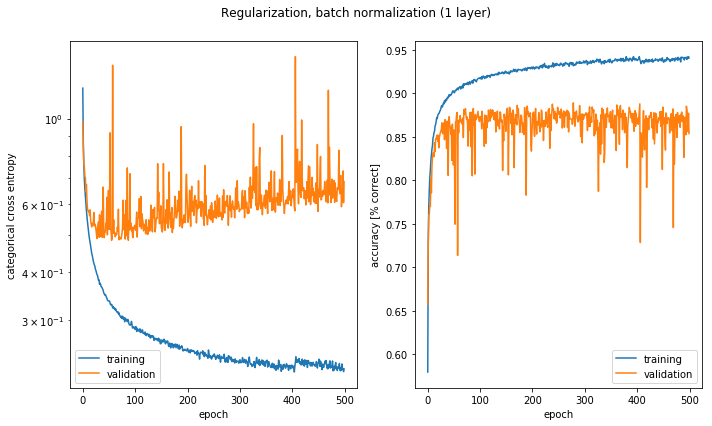

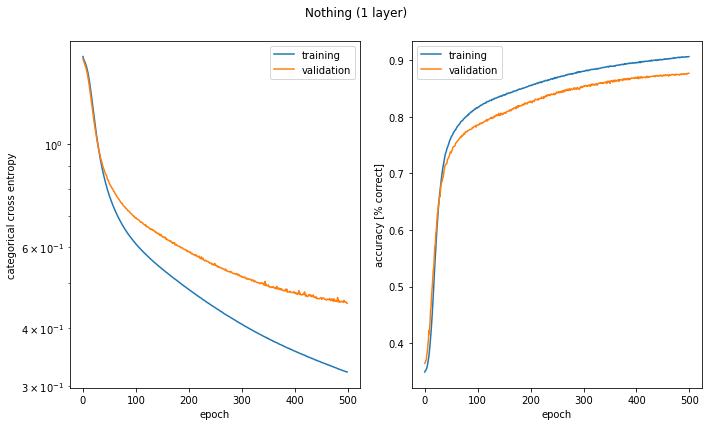

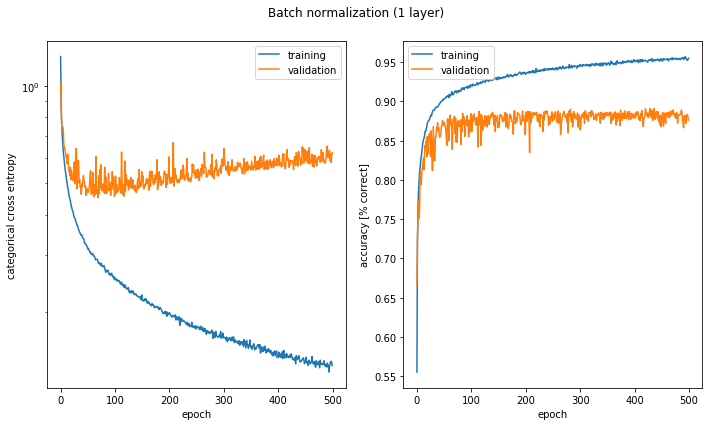

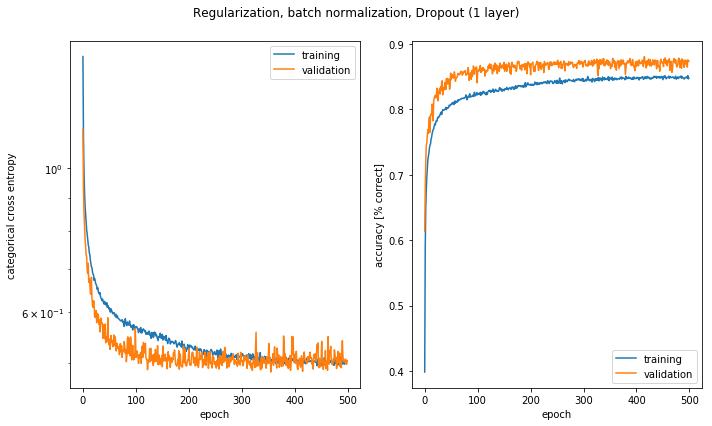

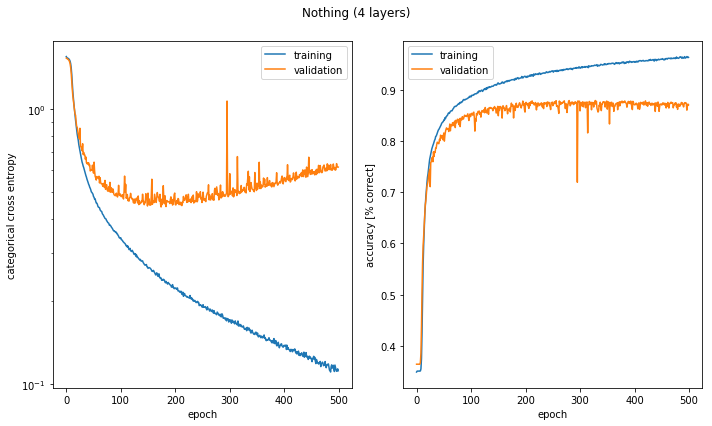

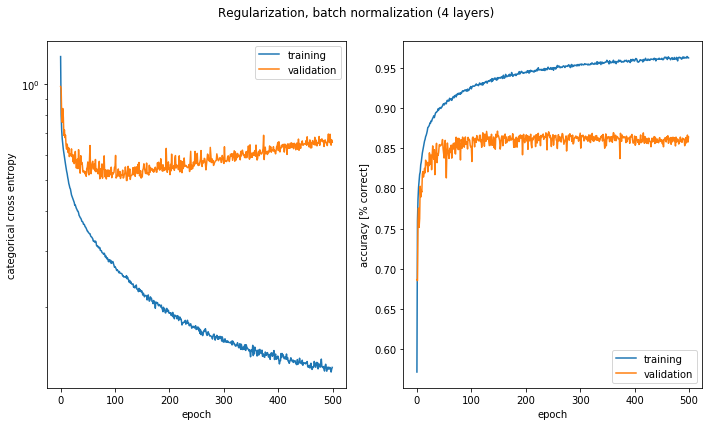

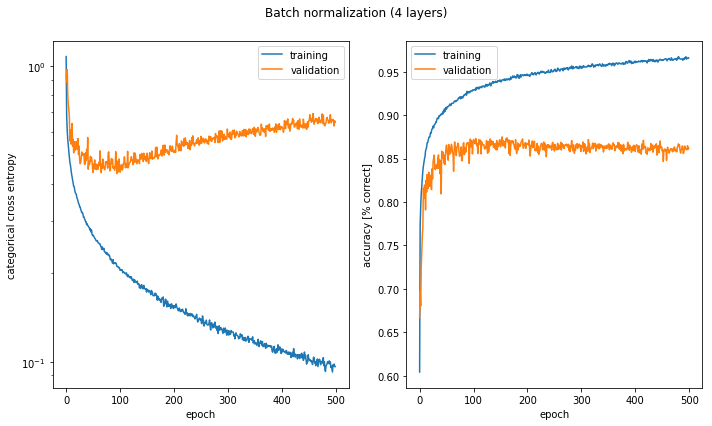

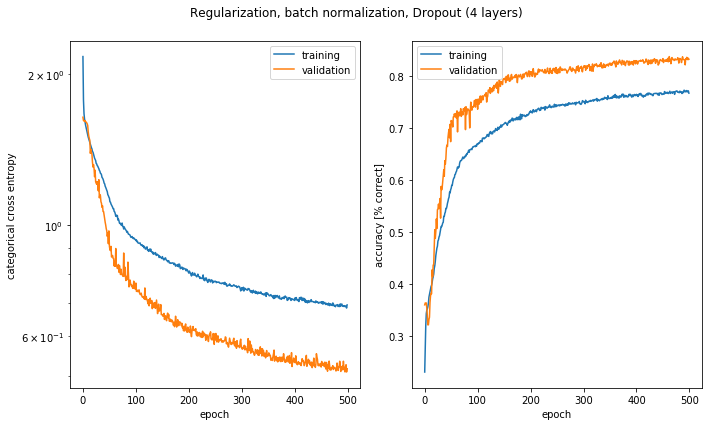

In [34]:
plot_history(h1, "Regularization, batch normalization (1 layer)")
plt.show()

plot_history(h2, "Nothing (1 layer)")
plt.show()

plot_history(h3, "Batch normalization (1 layer)")
plt.show()

plot_history(h4, "Regularization, batch normalization, Dropout (1 layer)")
plt.show()

plot_history(h5, "Nothing (4 layers)")
plt.show()

plot_history(h6, "Regularization, batch normalization (4 layers)")
plt.show()

plot_history(h7, "Batch normalization (4 layers)")
plt.show()

plot_history(h8, "Regularization, batch normalization, Dropout (4 layers)")
plt.show()

## Exercise 7: Convolutional networks

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with the parameters and fit it. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_cnn](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py).
2. Plot the learning curves of the convolutional neural network together with the so far best performing model.

## Solution

In [35]:
x_train_cnn = x_train.reshape(-1,16,16,1)
x_test_cnn = x_test.reshape(-1,16,16,1)

print('x_train shape:', x_train_cnn.shape)
print('x_test shape:', x_test_cnn.shape)
print(x_train_cnn.shape[0], 'train samples')
print(x_test_cnn.shape[0], 'test samples')

input_shape = x_train_cnn.shape
num_classes = 5
batch_size = 128


ex7_model = Sequential()
ex7_model.add(Conv2D(32, kernel_size=(3,3),
                 activation='relu',
                 input_shape=(16,16,1)))
ex7_model.add(Conv2D(64, (3, 3), padding='valid', activation='relu'))
ex7_model.add(MaxPooling2D(pool_size=(2, 2)))
ex7_model.add(Conv2D(150, (3, 3), activation='relu'))
ex7_model.add(Dropout(0.5))
ex7_model.add(Flatten())
ex7_model.add(Dense(300, activation='relu'))
ex7_model.add(Dropout(0.5))
ex7_model.add(Dense(num_classes, activation='softmax'))



x_train shape: (39523, 16, 16, 1)
x_test shape: (14002, 16, 16, 1)
39523 train samples
14002 test samples


In [36]:
ex7_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 150)         86550     
_________________________________________________________________
dropout_6 (Dropout)          (None, 4, 4, 150)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2400)              0         
_________________________________________________________________
dense_130 (Dense)            (None, 300)               720300    
__________

In [37]:
ex7_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

history = ex7_model.fit(x_train_cnn, y_train,
          batch_size=128,
          epochs=30,
          verbose=1,
          validation_data=(x_test_cnn, y_test))

score = ex7_model.evaluate(x_test_cnn, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 39523 samples, validate on 14002 samples
Epoch 1/30
39523/39523 [==============================] - 31s 774us/step - loss: 0.8790 - acc: 0.6584 - val_loss: 0.3705 - val_acc: 0.8739
Epoch 2/30
39523/39523 [==============================] - 27s 683us/step - loss: 0.3214 - acc: 0.8954 - val_loss: 0.2659 - val_acc: 0.9133
Epoch 3/30
39523/39523 [==============================] - 27s 694us/step - loss: 0.2558 - acc: 0.9169 - val_loss: 0.2468 - val_acc: 0.9224
Epoch 4/30
39523/39523 [==============================] - 28s 703us/step - loss: 0.2311 - acc: 0.9262 - val_loss: 0.2418 - val_acc: 0.9237
Epoch 5/30
39523/39523 [==============================] - 26s 669us/step - loss: 0.2086 - acc: 0.9319 - val_loss: 0.2092 - val_acc: 0.9333
Epoch 6/30
39523/39523 [==============================] - 26s 666us/step - loss: 0.1964 - acc: 0.9366 - val_loss: 0.1992 - val_acc: 0.9381
Epoch 7/30
39523/39523 [==============================] - 27s 674us/step - loss: 0.1819 - acc: 0.9416 - val_loss: 0.

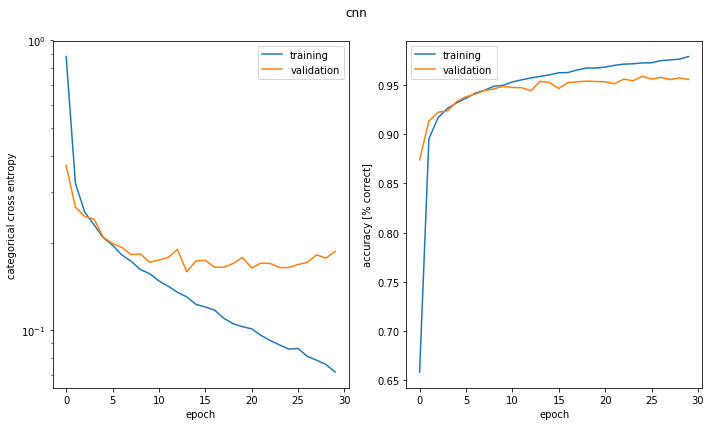

In [38]:
plot_history(history, "cnn")
plt.show()

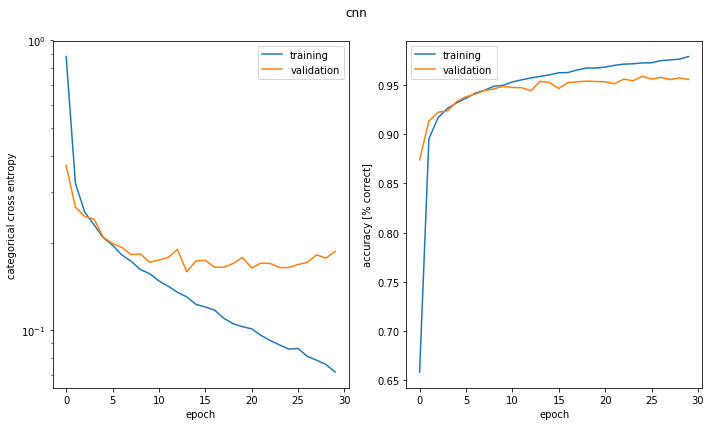

In [39]:
f1 = plot_history(history, "cnn")
plt.show()

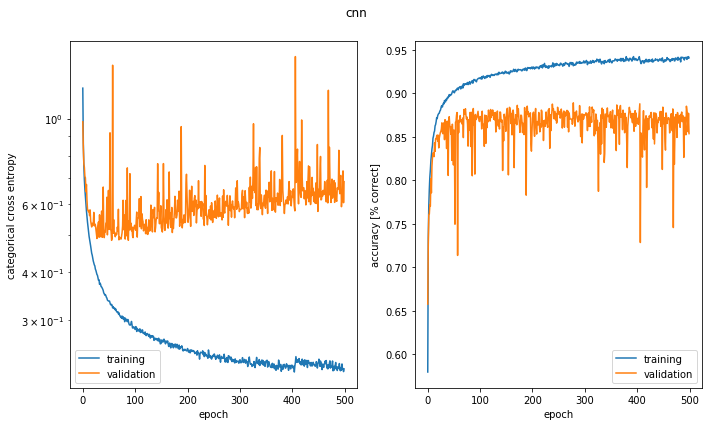

In [40]:
f2 = plot_history(h1,'cnn')

In [41]:
def plot_history_2(history, history2, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    ax1.plot(history2.history['loss'], label = "training")
    ax1.plot(history2.history['val_loss'], label = "validation")
    ax2.plot(history2.history['acc'], label = "training")
    ax2.plot(history2.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig

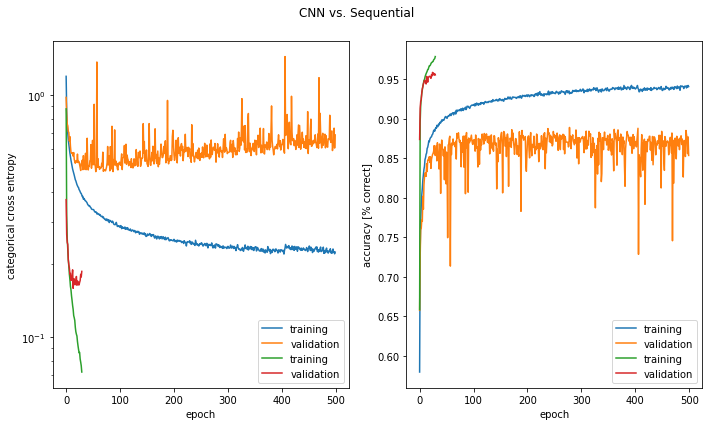

In [42]:
f3 = plot_history_2(h1,history,'CNN vs. Sequential')